In [132]:
import json

import decoupler as dc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
from sklearn.metrics import roc_curve, auc

In [133]:
# Generate simulated data
!uv run src/sim_data_generator_optimized.py simulated_data/parameters.json

{'output_dir': 'simulated_data/', 'output_exp_file': 'simulated_scRNASeq_data.tsv', 'output_prior_file': 'simulated_prior_data.tsv', 'output_ground_truth_file': 'simulated_ground_truth.tsv', 'n_cells': 5000, 'n_genes': 3000, 'n_tfs': 200, 'ground_truth_active_inactive_prob': 0.15, 'overlap_alpha_factor': 1, 'average_number_of_targets_per_tf': 30, 'tf_effect_factor': 1.15, 'missing_percentage': 0, 'random_seed': 8, 'distribution_type': 'negative_binomial'}
Generating prior data (Poisson targets)...
Generating gene expression data...
Generating gene expression data...
Zero percentage before dropout: 1.42554
No additional dropout applied.
Wrote prior to simulated_prior_data.tsv
Wrote ground truth to simulated_ground_truth.tsv
Wrote gene expression to simulated_scRNASeq_data.tsv


In [120]:
# # Plot stats of data
# def plot_hist_with_stats(data, ax, title, bins=90, color='red'):
#     sns.histplot(data, bins=bins, ax=ax, color=color, kde=True)
#     ax.set_title(title)
#     ax.set_xlabel('')
#     ax.set_ylabel('Count')
#
#     mean_val = np.mean(data)
#     median_val = np.median(data)
#     min_val = np.min(data)
#     max_val = np.max(data)
#
#     # Draw vertical lines
#     ax.axvline(mean_val, color='red', linestyle='--', linewidth=1, label=f'Mean = {mean_val:.3f}')
#     ax.axvline(median_val, color='green', linestyle='--', linewidth=1, label=f'Median = {median_val:.3f}')
#     ax.axvline(min_val, color='gray', linestyle=':', linewidth=1, label=f'Min = {min_val:.3f}')
#     ax.axvline(max_val, color='black', linestyle=':', linewidth=1, label=f'Max = {max_val:.3f}')
#
#     ax.legend(fontsize=8)
#
# # Calculate stats
# !uv run src/calculate_stat.py simulated_data/simulated_scRNASeq_data.tsv simulated_data/simulated_scRNASeq_data_stats.tsv
#
#
# stat_file = "simulated_data/simulated_scRNASeq_data_stats.tsv"
# stat_df = pd.read_csv(stat_file, sep="\t", index_col=0)
#
# # Some genes have all zero values. So the plot looks weird.
# fig, axs = plt.subplots(2, 3, figsize=(15, 10))
#
# plot_hist_with_stats(stat_df['mean_log'], axs[0, 0], 'Mean Distribution')
# plot_hist_with_stats(stat_df['std_log'], axs[0, 1], 'Standard Deviation Distribution')
# plot_hist_with_stats(stat_df['missing_ratio'], axs[0, 2], 'Missing Ratio Distribution')
# plot_hist_with_stats(stat_df['median_log'], axs[1, 0], 'Median Distribution')
# plot_hist_with_stats(stat_df['n_nonzero'], axs[1, 1], 'Non-zero Count Distribution')
#
# # Remove the last empty subplot
# fig.delaxes(axs[1, 2])
#
# plt.tight_layout()
# plt.show()

In [134]:
# Run kale without ignoring zeros
!uv run src/kale.py --gene_exp_file simulated_data/simulated_scRNASeq_data.tsv --prior_file simulated_data/simulated_prior_data.tsv --output_file simulated_data/_kale_scores.tsv --pvalue_output_file simulated_data/_kale_pvalues.tsv --ignore_zeros False --cores 8 --method rank_of_ranks --weighted False

Preprocessing gene expression data...
Using raw gene expression as input for per-cell ranking...
Starting TF activity using 8 cores.
Running in parallel with CORES_USED=8.
Processing cells in parallel: 100%|███████| 5000/5000 [00:03<00:00, 1281.37it/s]
[Parallel(n_jobs=8)]: Done 5000 out of 5000 | elapsed:    4.4s finished

Aggregating results...
kale completed
Kale TF activity scores and p-values have been saved.


In [122]:
# Run kale with ignoring zeros
# !uv run src/kale.py --gene_exp_file simulated_data/simulated_scRNASeq_data.tsv --prior_file simulated_data/simulated_prior_data.tsv --output_file simulated_data/_kale_scores_ignore_zeros.tsv --pvalue_output_file simulated_data/_kale_pvalues_ignore_zeros.tsv --ignore_zeros True --cores 8 --method rank_of_ranks

In [135]:
# Gene Expression data
gene_exp_file = "simulated_data/simulated_scRNASeq_data.tsv"

gene_exp = pd.read_csv(gene_exp_file, sep="\t", index_col=0)
adata = sc.AnnData(gene_exp)

# 1. Normalize (Corrects sequencing depth)
sc.pp.normalize_total(adata, target_sum=1e4)
# 2. Log transform (Stabilizes variance / makes data Gaussian-like)
sc.pp.log1p(adata)
# 3. Scale (Optional for ULM/MLM, Highly Recommended for VIPER)
sc.pp.scale(adata, max_value=10)

adata

AnnData object with n_obs × n_vars = 5000 × 3000
    var: 'mean', 'std'
    uns: 'log1p'

In [136]:
# Prior Knowledge Network
net_file = "simulated_data/simulated_prior_data.tsv"

effect_map = {"upregulates-expression": 1, "downregulates-expression": -1}

net = pd.read_csv(
    net_file,
    sep="\t",
    names=["source", "weight", "target"],
    usecols=[0, 1, 2],
    converters={"weight": effect_map.get}
)[["source", "target", "weight"]]

net.head()

,source,target,weight
0,TF_1,G_2998,-1
1,TF_1,G_2819,1
2,TF_1,G_195,1
3,TF_1,G_1656,-1
4,TF_1,G_1828,1


### Plot stats of prior knowledge network

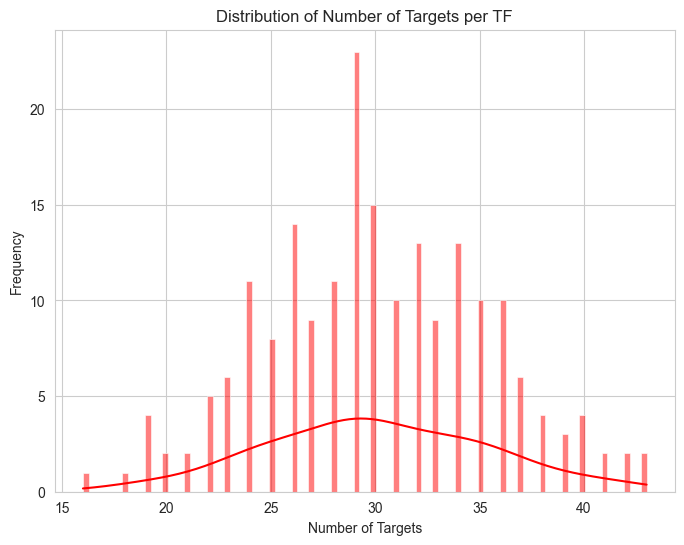

In [125]:
# group the net by source and count the number of targets
net_grouped = net.groupby("source").size().reset_index(name="num_targets")
# Plot histogram of num_targets
plt.figure(figsize=(8, 6))
sns.histplot(net_grouped["num_targets"], bins=100, kde=True, color='red')
plt.title("Distribution of Number of Targets per TF")
plt.xlabel("Number of Targets")
plt.ylabel("Frequency")
plt.show()

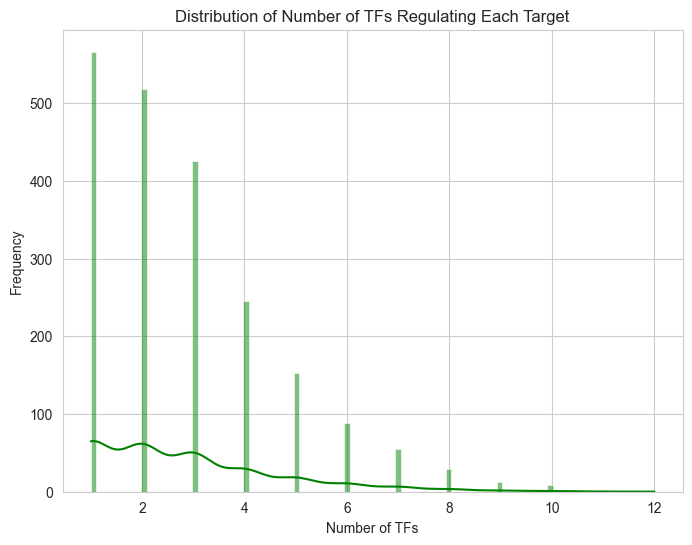

In [126]:
# Count for each target, how many TFs regulate it
target_grouped = net.groupby("target").size().reset_index(name="num_tfs")

# Plot histogram of num_tfs
plt.figure(figsize=(8, 6))
sns.histplot(target_grouped["num_tfs"], bins=100, kde=True, color='green')
plt.title("Distribution of Number of TFs Regulating Each Target")
plt.xlabel("Number of TFs")
plt.ylabel("Frequency")
plt.show()

In [127]:
# # Calculate the overalap between top 5 TFs with most targets i.e each first 5 TFs to each other
# top_tfs = net_grouped.sort_values(by="source", ascending=False).head(10)
#
# overlaps = []
# for i in range(len(top_tfs)):
#     for j in range(i + 1, len(top_tfs)):
#         tf1 = top_tfs.iloc[i]
#         tf2 = top_tfs.iloc[j]
#         targets_tf1 = set(net[net["source"] == tf1["source"]]["target"])
#         targets_tf2 = set(net[net["source"] == tf2["source"]]["target"])
#         overlap = targets_tf1.intersection(targets_tf2)
#         print(f"{tf1['source']}: {tf1['num_targets']} targets, \t {tf2['source']}: {tf2['num_targets']} targets.")
#         print(f"\t No. of overlapping targets: {len(overlap)} ...............")
#         overlaps.append(len(overlap))
#
# print("-----")
# print("Average overlap among top 5 TFs:", np.mean(overlaps))

In [128]:
# net_grouped

In [129]:
# # Prior Knowledge Network
# net_file = "data/causal_priors.tsv"
#
# effect_map = {"upregulates-expression": 1, "downregulates-expression": -1}
#
# net = pd.read_csv(
#     net_file,
#     sep="\t",
#     names=["source", "weight", "target"],
#     usecols=[0, 1, 2],
#     converters={"weight": effect_map.get}
# )[["source", "target", "weight"]]
#
# net.head()
#
# # group the net by source and count number of targets
# net_grouped = net.groupby("source").size().reset_index(name="num_targets")
# # Plot histogram of num_targets
# plt.figure(figsize=(8, 6))
# sns.histplot(net_grouped["num_targets"], bins=100, kde=True, color='red')
# plt.title("Distribution of Number of Targets per TF")
# plt.xlabel("Number of Targets")
# plt.ylabel("Frequency")
# plt.show()

### Ground Truths and ROC Curve

In [137]:
# Ground Truths
ground_truths_file = "simulated_data/simulated_ground_truth.tsv"

ground_truths = pd.read_csv(ground_truths_file, sep="\t", index_col=0)
ground_truths = ground_truths.reset_index().rename(columns={"index": "Cell"})
ground_truths = pd.melt(ground_truths, id_vars=["Cell"], var_name="TF", value_name="Value")
ground_truths["Cell_TF"] = ground_truths["Cell"] + "_" + ground_truths["TF"]
ground_truths = ground_truths[["Cell_TF", "Value"]]

print(f"Ground truths shape: {ground_truths.shape}")
print(ground_truths.head(10))

Ground truths shape: (1000000, 2)
        Cell_TF  Value
0   Cell_1_TF_1      0
1   Cell_2_TF_1      0
2   Cell_3_TF_1      1
3   Cell_4_TF_1      0
4   Cell_5_TF_1      0
5   Cell_6_TF_1      0
6   Cell_7_TF_1      0
7   Cell_8_TF_1      0
8   Cell_9_TF_1      0
9  Cell_10_TF_1      0


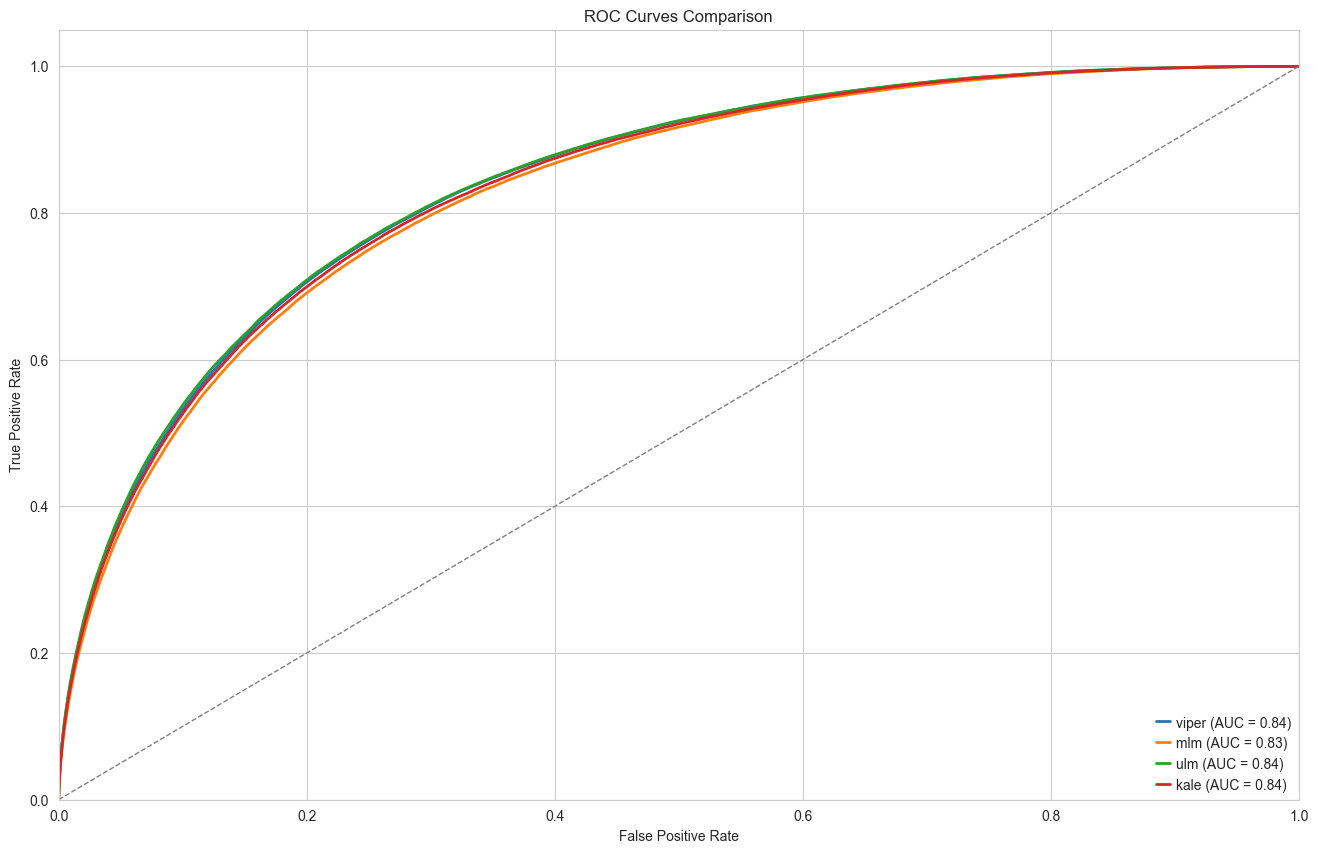

In [138]:
methods_to_run = ["viper", "mlm", "ulm"]

dc.mt.decouple(adata, net, tmin=0, methods=methods_to_run)

plt.figure(figsize=(16, 10))
methods_to_run.append("kale")

for method in methods_to_run:
    if method == "kale":
        method_scores = pd.read_csv("simulated_data/_kale_scores.tsv", sep="\t", index_col=0)
    else:
        method_scores = adata.obsm[f"score_{method}"]

    # Melt the DataFrame to long format
    scores_out = method_scores.reset_index().rename(columns={"index": "Cell"})
    scores_out = pd.melt(scores_out, id_vars=["Cell"], var_name="TF", value_name="Value")
    scores_out["Cell_TF"] = scores_out["Cell"] + "_" + scores_out["TF"]
    scores_out = scores_out[["Cell_TF", "Value"]]

    # Merge with ground truths
    scores_merged = scores_out.merge(ground_truths, on="Cell_TF", suffixes=("_pred", "_true"))

    # Sort by Cell_TF to ensure consistent ordering
    scores_merged = scores_merged.sort_values(by="Value_pred", ascending=False)
    scores_merged['y_true'] = (scores_merged['Value_true'] == 1.0).astype(int)

    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(scores_merged['y_true'], scores_merged['Value_pred'])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{method} (AUC = {roc_auc:.2f})")


plt.plot([0, 1], [0, 1], color="gray", lw=1, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves Comparison")
plt.legend(loc="lower right")
plt.show()

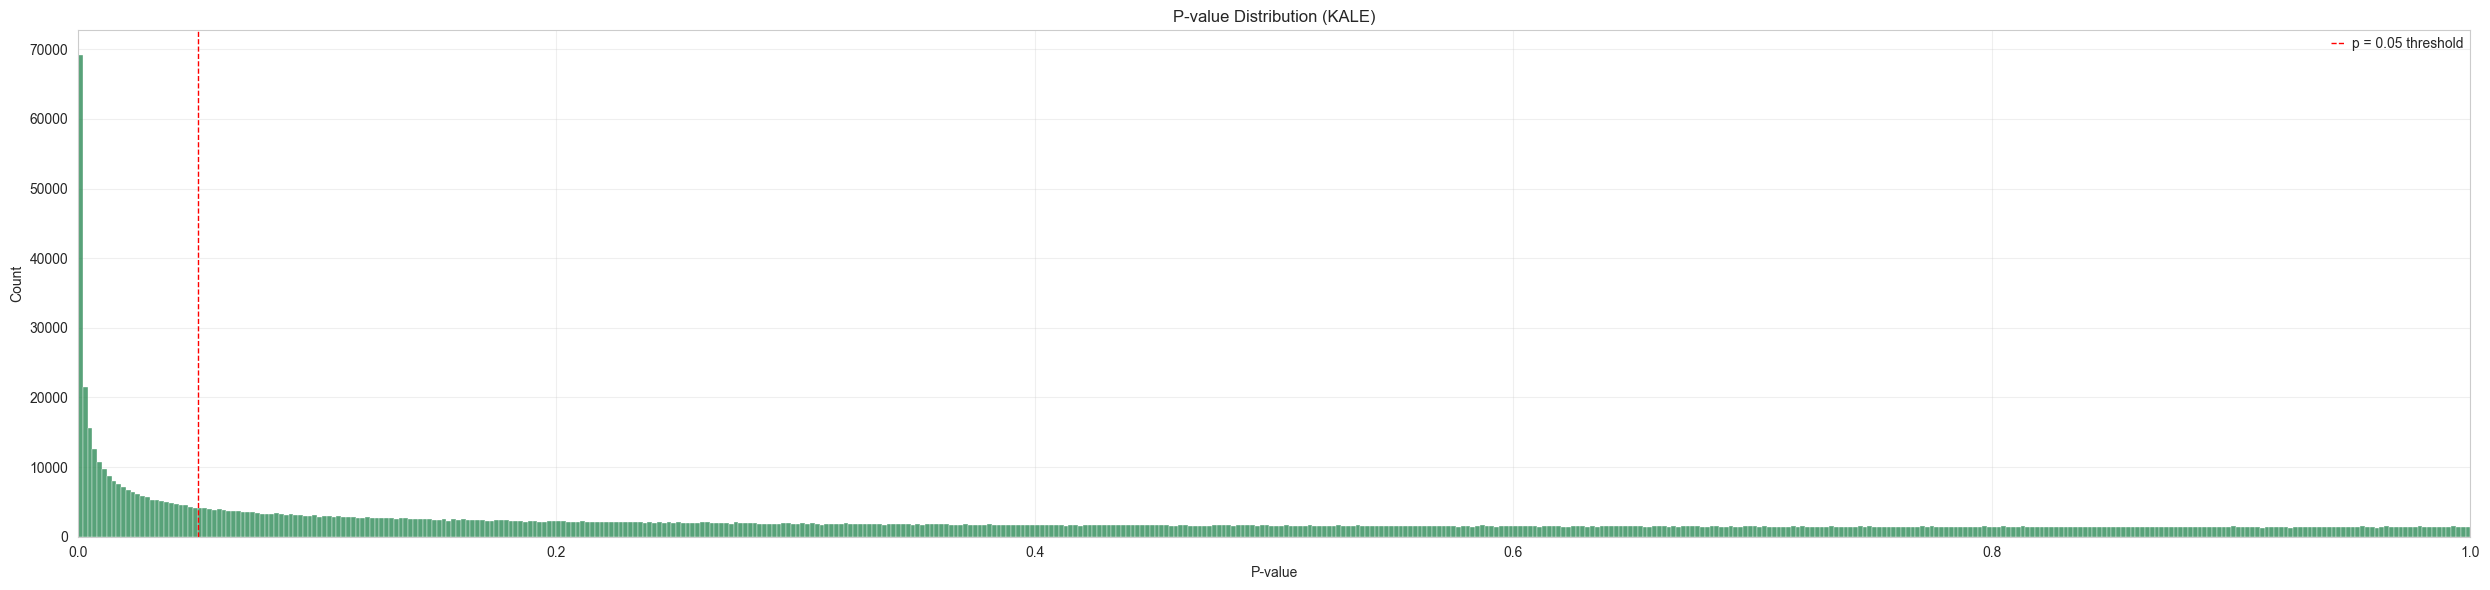

In [184]:
# Load
pvalues = pd.read_csv("simulated_data/_kale_pvalues.tsv", sep="\t", index_col=0)

flat_p = pvalues.values.flatten()

# Plot
plt.figure(figsize=(25, 6))
sns.histplot(flat_p, bins=500, color='seagreen', alpha=0.8, kde=False)
plt.axvline(0.05, color='red', linestyle='--', linewidth=1, label='p = 0.05 threshold')

# Labels
plt.title("P-value Distribution (KALE)")
plt.xlabel("P-value")
plt.ylabel("Count")
plt.xlim(0, 1)
plt.legend(frameon=False)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

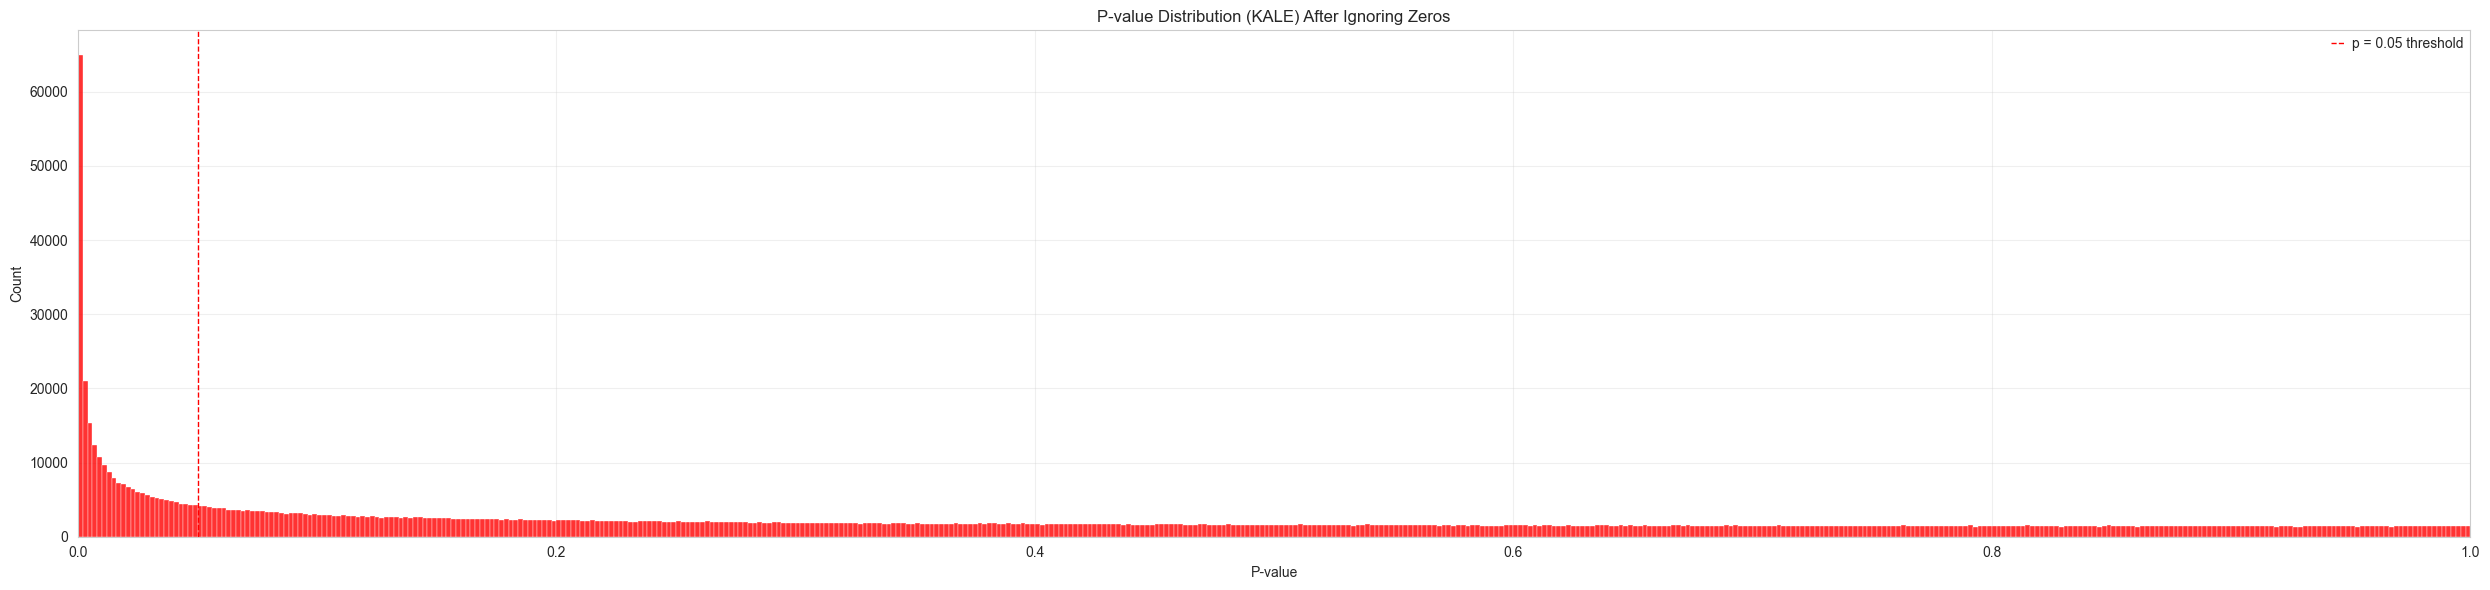

In [185]:
# Load
pvalues = pd.read_csv("simulated_data/_kale_pvalues_ignore_zeros.tsv", sep="\t", index_col=0)

flat_p = pvalues.values.flatten()

# Plot
plt.figure(figsize=(25, 6))
sns.histplot(flat_p, bins=500, color='red', alpha=0.8, kde=False)
plt.axvline(0.05, color='red', linestyle='--', linewidth=1, label='p = 0.05 threshold')

# Labels
plt.title("P-value Distribution (KALE) After Ignoring Zeros")
plt.xlabel("P-value")
plt.ylabel("Count")
plt.xlim(0, 1)
plt.legend(frameon=False)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# Plot pvalue cummulative distribution

In [965]:
# Running methods Pipeline
# 1. Generate simulated data
!uv run src/sim_data_generator_optimized.py simulated_data/parameters.json

# 2. Run kale without ignoring zeros
!uv run src/kale.py --gene_exp_file simulated_data/simulated_scRNASeq_data.tsv --prior_file simulated_data/simulated_prior_data.tsv --output_file simulated_data/_kale_scores.tsv --pvalue_output_file simulated_data/_kale_pvalues.tsv --ignore_zeros False --cores 8 --method rank_of_ranks --weighted False

# 3. Run kale with ignoring zeros
!uv run src/kale.py --gene_exp_file simulated_data/simulated_scRNASeq_data.tsv --prior_file simulated_data/simulated_prior_data.tsv --output_file simulated_data/_kale_scores_ignore_zeros.tsv --pvalue_output_file simulated_data/_kale_pvalues_ignore_zeros.tsv --ignore_zeros True --cores 8 --method rank_of_ranks

# 4. Gene Expression data
gene_exp_file = "simulated_data/simulated_scRNASeq_data.tsv"
gene_exp = pd.read_csv(gene_exp_file, sep="\t", index_col=0)
adata = sc.AnnData(gene_exp)

# 5. Prior Knowledge Network
net_file = "simulated_data/simulated_prior_data.tsv"
effect_map = {"upregulates-expression": 1, "downregulates-expression": -1}
net = pd.read_csv(
    net_file,
    sep="\t",
    names=["source", "weight", "target"],
    usecols=[0, 1, 2],
    converters={"weight": effect_map.get}
)[["source", "target", "weight"]]

# 6. Ground Truths
ground_truths_file = "simulated_data/simulated_ground_truth.tsv"
ground_truths = pd.read_csv(ground_truths_file, sep="\t", index_col=0)
ground_truths = ground_truths.reset_index().rename(columns={"index": "Cell"})
ground_truths = pd.melt(ground_truths, id_vars=["Cell"], var_name="TF", value_name="Value")
ground_truths["Cell_TF"] = ground_truths["Cell"] + "_" + ground_truths["TF"]
ground_truths = ground_truths[["Cell_TF", "Value"]]

# 7. Other methods
methods_to_run = ["viper", "mlm"]
dc.mt.decouple(adata, net, tmin=1, methods=methods_to_run)

# 8. ROC Curve plotting
methods_to_run.append("kale")
methods_to_run.append("kale_ignore_zeros")
for method in methods_to_run:
    if method == "kale":
        method_scores = pd.read_csv("simulated_data/_kale_scores.tsv", sep="\t", index_col=0)
    elif method == "kale_ignore_zeros":
        method_scores = pd.read_csv("simulated_data/_kale_scores_ignore_zeros.tsv", sep="\t", index_col=0)
    else:
        # Get the scores for the current method
        method_scores = adata.obsm[f"score_{method}"]

    # Melt the DataFrame to long format
    scores_out = method_scores.reset_index().rename(columns={"index": "Cell"})
    scores_out = pd.melt(scores_out, id_vars=["Cell"], var_name="TF", value_name="Value")
    scores_out["Cell_TF"] = scores_out["Cell"] + "_" + scores_out["TF"]
    scores_out = scores_out[["Cell_TF", "Value"]]

    # Merge with ground truths
    scores_merged = scores_out.merge(ground_truths, on="Cell_TF", suffixes=("_pred", "_true"))

    # Sort by Cell_TF to ensure consistent ordering
    scores_merged = scores_merged.sort_values(by="Value_pred", ascending=False)
    scores_merged['y_true'] = (scores_merged['Value_true'] == 1.0).astype(int)

    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(scores_merged['y_true'], scores_merged['Value_pred'])
    roc_auc = auc(fpr, tpr)
    print(f"{method} AUC: {roc_auc:.4f}")


NameError: name 'End' is not defined

# parameters.json test suite

## No missing values scenario

In [31]:
final_result = []
test_suite = []
prior_pairwise_overlap_stats = {}

alpha_values = [0, 2, 4]
average_targets = [30, 50]


for alpha in alpha_values:
    for avg_targets in average_targets:
        test_case = {
            "output_dir": "simulated_data/",
            "output_exp_file": "simulated_scRNASeq_data.tsv",
            "output_prior_file": "simulated_prior_data.tsv",
            "output_ground_truth_file": "simulated_ground_truth.tsv",
            "n_cells": 1000,
            "n_genes": 1000,
            "n_tfs": 100,
            "ground_truth_active_inactive_prob": 0.1,
            "overlap_alpha_factor": alpha,
            "average_number_of_targets_per_tf": avg_targets,
            "tf_effect_factor": 1.25,
            "missing_percentage": 0,
            "random_seed": 28,
            "distribution_type": "negative_binomial"
        }
        test_suite.append(test_case)

for i, test_case in enumerate(test_suite):
    with open("simulated_data/parameters.json", "w") as f:
        json.dump(test_case, f, indent=4)

    # 1. Generate simulated data
    print("\nGenerating simulated data for test case", i + 1)
    !uv run src/sim_data_generator_optimized.py simulated_data/parameters.json


    # 2. Run kale without
    print("\nRunning KALE for test case", i + 1)
    !uv run src/kale.py --gene_exp_file simulated_data/simulated_scRNASeq_data.tsv --prior_file simulated_data/simulated_prior_data.tsv --output_file simulated_data/_kale_scores.tsv --pvalue_output_file simulated_data/_kale_pvalues.tsv --ignore_zeros False --cores 8 --method rank_of_ranks --weighted False


    # 2.1 Run with a weighted option 1
    print("\nRunning KALE with weights for test case", i + 1)
    !uv run src/kale_archive.py --gene_exp_file simulated_data/simulated_scRNASeq_data.tsv --prior_file simulated_data/simulated_prior_data.tsv --output_file simulated_data/_kale_scores_weighted_option1.tsv --pvalue_output_file simulated_data/_kale_pvalues_weighted_option1.tsv --ignore_zeros False --cores 8 --method rank_of_ranks --weighted True

    # 2.2 Run with a weighted option 2
    print("\nRunning KALE with weights for test case", i + 1)
    !uv run src/kale.py --gene_exp_file simulated_data/simulated_scRNASeq_data.tsv --prior_file simulated_data/simulated_prior_data.tsv --output_file simulated_data/_kale_scores_weighted_option2.tsv --pvalue_output_file simulated_data/_kale_pvalues_weighted_option2.tsv --ignore_zeros False --cores 8 --method rank_of_ranks --weighted True


    # 3. Run kale with ignoring zeros
    print("\n\nRunning KALE with ignoring zeros for test case", i + 1)
    !uv run src/kale.py --gene_exp_file simulated_data/simulated_scRNASeq_data.tsv --prior_file simulated_data/simulated_prior_data.tsv --output_file simulated_data/_kale_scores_ignore_zeros.tsv --pvalue_output_file simulated_data/_kale_pvalues_ignore_zeros.tsv --ignore_zeros True --cores 8 --method rank_of_ranks


    # 4. Gene Expression data
    gene_exp_file = "simulated_data/simulated_scRNASeq_data.tsv"
    gene_exp = pd.read_csv(gene_exp_file, sep="\t", index_col=0)
    adata = sc.AnnData(gene_exp)
    # 1. Normalize (Corrects sequencing depth)
    sc.pp.normalize_total(adata, target_sum=1e4)
    # 2. Log transform (Stabilizes variance / makes data Gaussian-like)
    sc.pp.log1p(adata)
    # 3. Scale (Optional for ULM/MLM, Highly Recommended for VIPER)
    sc.pp.scale(adata, max_value=10)

    # 5. Prior Knowledge Network
    net_file = "simulated_data/simulated_prior_data.tsv"
    effect_map = {"upregulates-expression": 1, "downregulates-expression": -1}
    net = pd.read_csv(
        net_file,
        sep="\t",
        names=["source", "weight", "target"],
        usecols=[0, 1, 2],
        converters={"weight": effect_map.get}
    )[["source", "target", "weight"]]

    # 5.1 Pairwise Overlap Stats
    unique_tfs = net['source'].unique()
    group_size = 5
    overlap_coefficient_list = []
    for p in range(0, len(unique_tfs), group_size):
        current_tfs = unique_tfs[p:p + group_size]
        overlap_coefficient = []
        for j in range(len(current_tfs)):
            for k in range(j + 1, len(current_tfs)):
                targets_tf1 = set(net[net['source'] == current_tfs[j]]['target'])
                targets_tf2 = set(net[net['source'] == current_tfs[k]]['target'])
                intersection_targets = targets_tf1.intersection(targets_tf2)
                overlap_coefficient.append(len(intersection_targets) / min(len(targets_tf1), len(targets_tf2)))
        overlap_coefficient_list.append(overlap_coefficient)
    average_groupwise_overlap_coefficient = [sum(group) / len(group) for group in overlap_coefficient_list]
    prior_pairwise_overlap_stats[
        f"{test_case['overlap_alpha_factor']}_{test_case['average_number_of_targets_per_tf']}"] = overlap_coefficient_list

    # 6. Ground Truths
    ground_truths_file = "simulated_data/simulated_ground_truth.tsv"
    ground_truths = pd.read_csv(ground_truths_file, sep="\t", index_col=0)
    ground_truths = ground_truths.reset_index().rename(columns={"index": "Cell"})
    ground_truths = pd.melt(ground_truths, id_vars=["Cell"], var_name="TF", value_name="Value")
    ground_truths["Cell_TF"] = ground_truths["Cell"] + "_" + ground_truths["TF"]
    ground_truths = ground_truths[["Cell_TF", "Value"]]

    # 7. Run other methods
    print("\nRunning Viper and MLM...")
    methods_to_run = ["viper", "mlm", "ulm"]
    dc.mt.decouple(adata, net, tmin=1, methods=methods_to_run)

    # 8. Compute AUC for each method
    print("Computing AUC for each method...")
    methods_to_run.append("kale")
    methods_to_run.append("weighted_kale_option1")
    methods_to_run.append("weighted_kale_option2")
    methods_to_run.append("kale_ignore_zeros")

    for method in methods_to_run:
        if method == "kale":
            method_scores = pd.read_csv("simulated_data/_kale_scores.tsv", sep="\t", index_col=0)
        elif method == "kale_ignore_zeros":
            method_scores = pd.read_csv("simulated_data/_kale_scores_ignore_zeros.tsv", sep="\t", index_col=0)
        elif method == "weighted_kale_option1":
            method_scores = pd.read_csv("simulated_data/_kale_scores_weighted_option1.tsv", sep="\t", index_col=0)
        elif method == "weighted_kale_option2":
            method_scores = pd.read_csv("simulated_data/_kale_scores_weighted_option2.tsv", sep="\t", index_col=0)
        else:
            method_scores = adata.obsm[f"score_{method}"]

        ##### Missing Check #####
        missing_count = method_scores.isnull().sum().sum()
        if missing_count > 0:
            print("*" * 150 + " ," + method)
            print(f"Warning: {missing_count} missing values found in {method} scores. Filling with 0.")
            method_scores = method_scores.fillna(0)
            # Find row and column indexes with missing values
            missing_rows, missing_cols = np.where(method_scores.isnull())
            for row, col in zip(missing_rows, missing_cols):
                print(f"Missing value at row {method_scores.index[row]}, column {method_scores.columns[col]}")
            print("*" * 150)
        #########################

        # Melt the DataFrame to long format
        scores_out = method_scores.reset_index().rename(columns={"index": "Cell"})
        scores_out = pd.melt(scores_out, id_vars=["Cell"], var_name="TF", value_name="Value")
        scores_out["Cell_TF"] = scores_out["Cell"] + "_" + scores_out["TF"]
        scores_out = scores_out[["Cell_TF", "Value"]]

        # Merge with ground truths
        scores_merged = scores_out.merge(ground_truths, on="Cell_TF", suffixes=("_pred", "_true"))

        # Sort by Cell_TF to ensure consistent ordering
        scores_merged = scores_merged.sort_values(by="Value_pred", ascending=False)
        scores_merged['y_true'] = (scores_merged['Value_true'] == 1.0).astype(int)

        # Compute ROC curve and AUC
        fpr, tpr, _ = roc_curve(scores_merged['y_true'], scores_merged['Value_pred'])
        roc_auc = auc(fpr, tpr)

        # collect AUC results
        test_case["auc_" + method] = roc_auc

    final_result.append(test_case)

# 8. Save final results to a CSV file
final_result_df = pd.DataFrame(final_result)
final_result_df.drop(
    ['output_dir', 'output_exp_file', 'output_prior_file', 'output_ground_truth_file', 'distribution_type'], axis=1,
    inplace=True)
final_result_df.to_csv("simulated_data/simulation_test_suite_results_with_overlap_k_5_overlap_coefficient.tsv",
                       index=False, sep="\t")

# 9. Save prior pairwise overlap stats in tsv
overlap_stats_df = pd.DataFrame(prior_pairwise_overlap_stats)
overlap_stats_df.to_csv("simulated_data/pairwise_overlap_histogram_k_5_overlap_coefficient.tsv", index=False, sep="\t")



Generating simulated data for test case 1
{'output_dir': 'simulated_data/', 'output_exp_file': 'simulated_scRNASeq_data.tsv', 'output_prior_file': 'simulated_prior_data.tsv', 'output_ground_truth_file': 'simulated_ground_truth.tsv', 'n_cells': 1000, 'n_genes': 1000, 'n_tfs': 100, 'ground_truth_active_inactive_prob': 0.1, 'overlap_alpha_factor': 0, 'average_number_of_targets_per_tf': 30, 'tf_effect_factor': 1.25, 'missing_percentage': 0, 'random_seed': 28, 'distribution_type': 'negative_binomial'}
Generating prior data (Poisson targets)...
Generating gene expression data...
Generating gene expression data...
Zero percentage before dropout: 0.1488
No additional dropout applied.
Wrote prior to simulated_prior_data.tsv
Wrote ground truth to simulated_ground_truth.tsv
Wrote gene expression to simulated_scRNASeq_data.tsv

Running KALE for test case 1
Preprocessing gene expression data...
Using raw gene expression as input for per-cell ranking...
Starting TF activity using 8 cores.
Running i

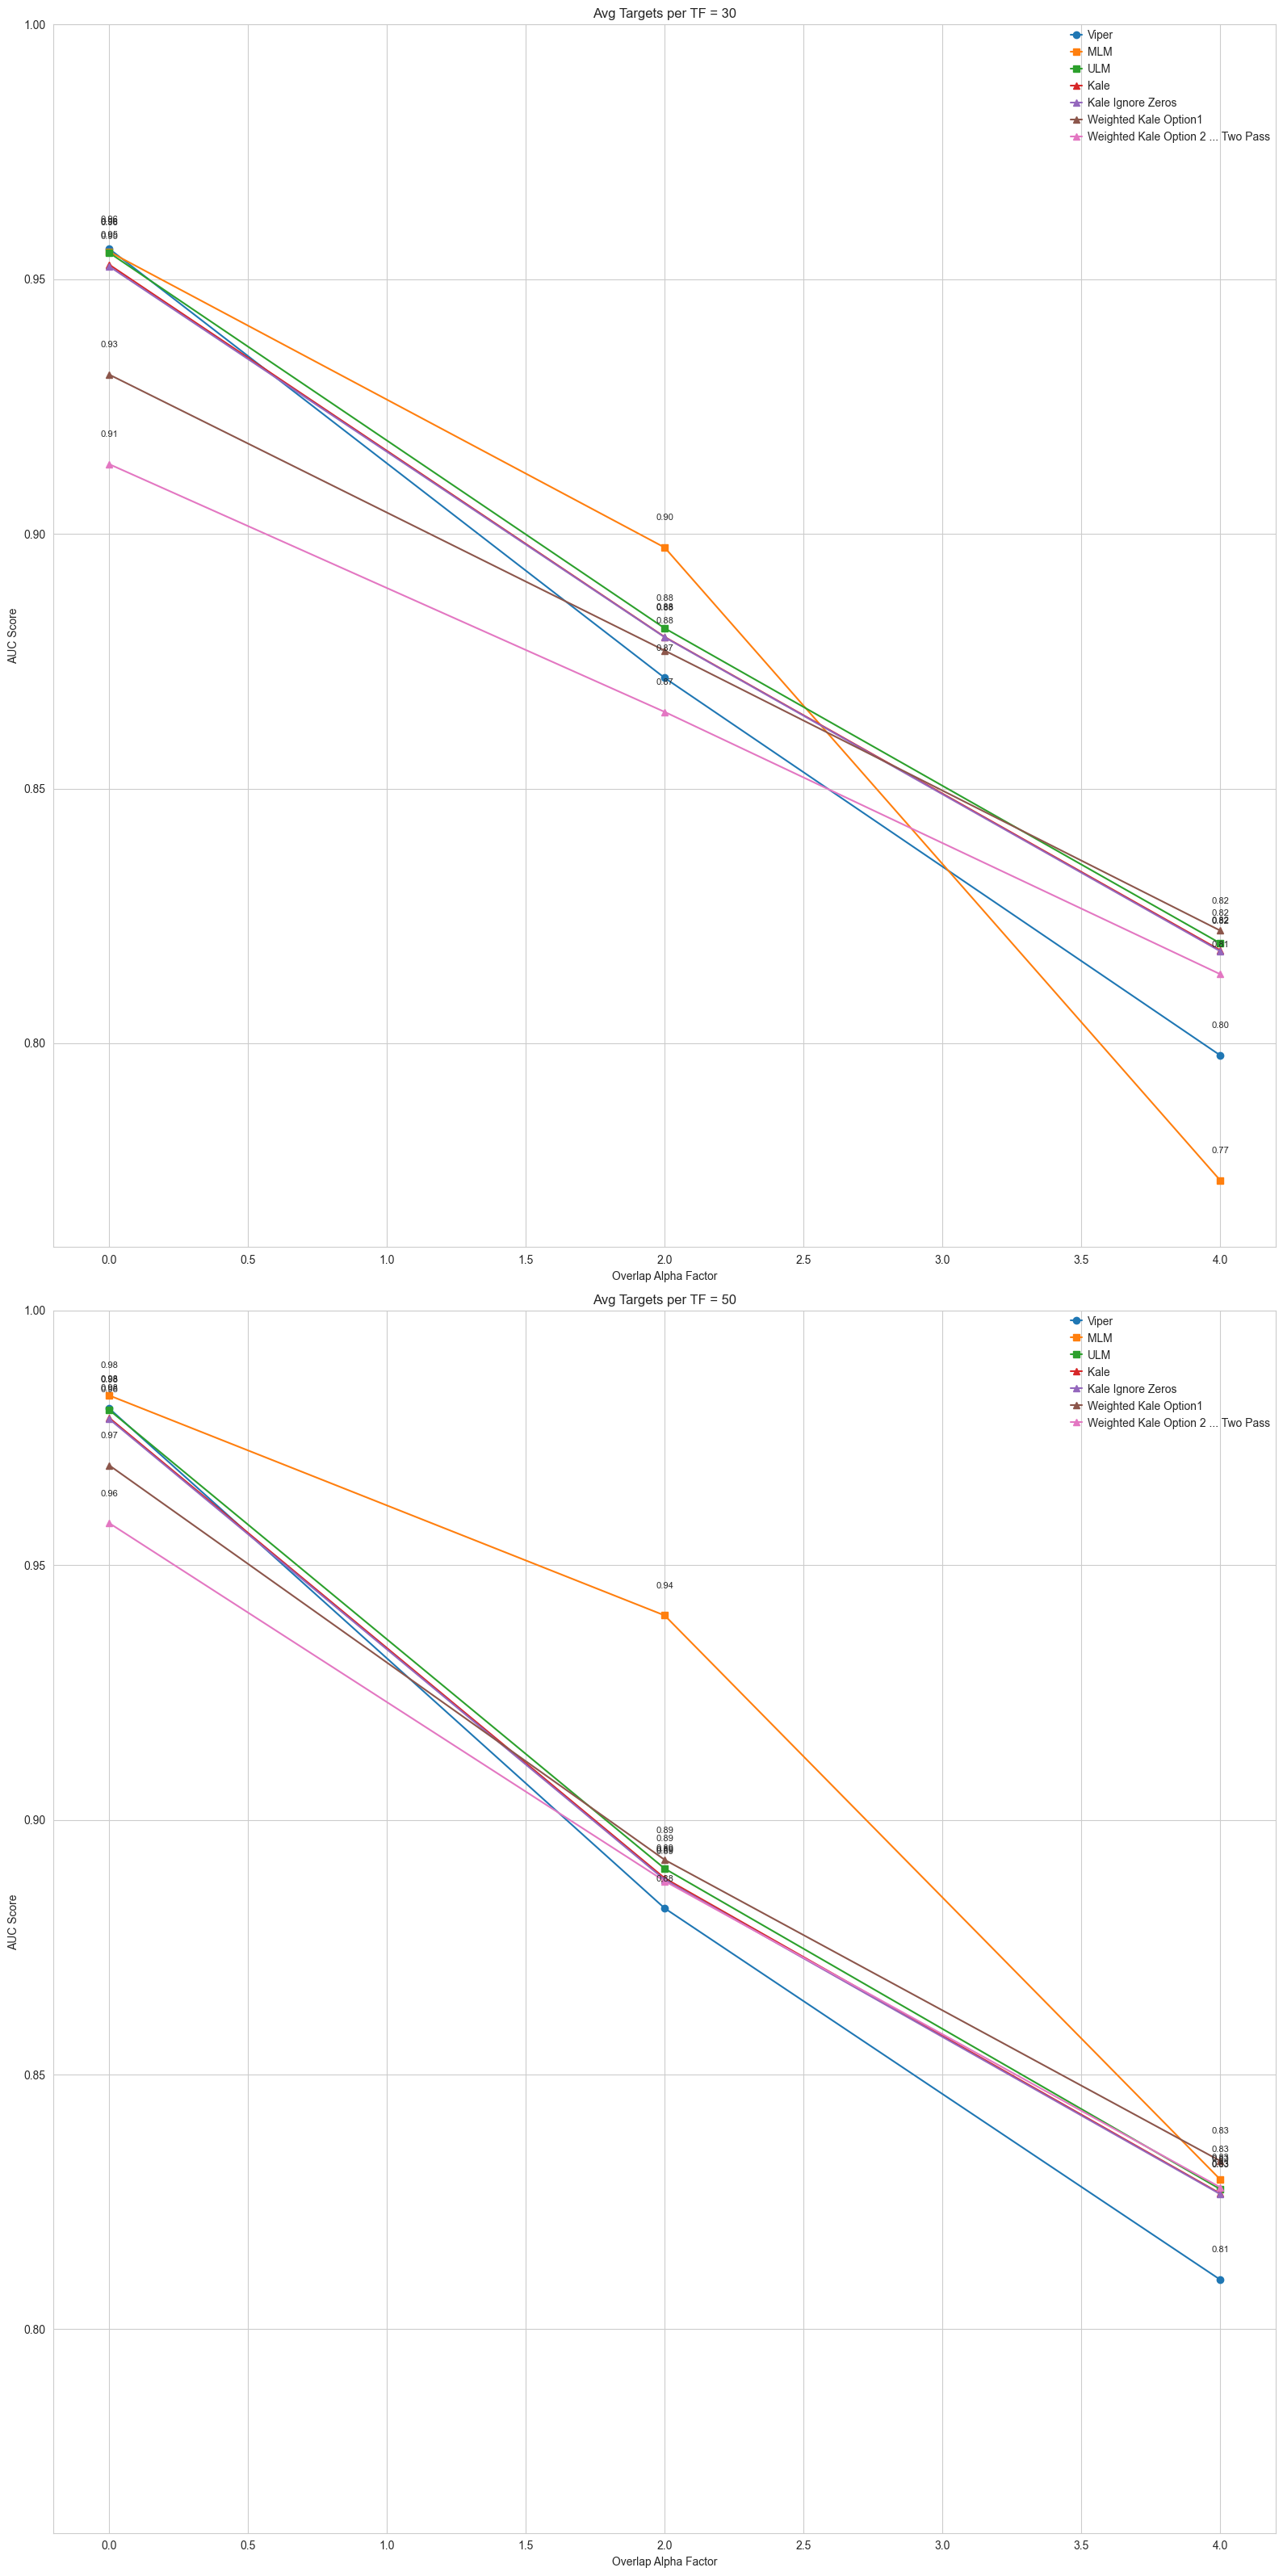

In [36]:
# Load data
final_result_df = pd.read_csv(
    "simulated_data/simulation_test_suite_results_with_overlap_k_5_overlap_coefficient.tsv",
    sep="\t"
)
# Unique target counts
unique_targets = sorted(final_result_df['average_number_of_targets_per_tf'].unique())

# Setup figure
fig, axes = plt.subplots(len(unique_targets), 1, figsize=(16, 16 * len(unique_targets)))
if len(unique_targets) == 1:
    axes = [axes]

# Plot
for i, n_targets in enumerate(unique_targets):
    ax = axes[i]
    n_targets_results = final_result_df[final_result_df['average_number_of_targets_per_tf'] == n_targets]

    alpha_values = sorted(n_targets_results['overlap_alpha_factor'].unique())

    ax.plot(alpha_values, n_targets_results['auc_viper'], marker='o', label='Viper')
    ax.plot(alpha_values, n_targets_results['auc_mlm'], marker='s', label='MLM')
    ax.plot(alpha_values, n_targets_results['auc_ulm'], marker='s', label='ULM')
    ax.plot(alpha_values, n_targets_results['auc_kale'], marker='^', label='Kale')
    ax.plot(alpha_values, n_targets_results['auc_kale_ignore_zeros'], marker='^', label='Kale Ignore Zeros')
    ax.plot(alpha_values, n_targets_results['auc_weighted_kale_option1'], marker='^', label='Weighted Kale Option1')
    ax.plot(alpha_values, n_targets_results['auc_weighted_kale_option2'], marker='^',
            label='Weighted Kale Option 2 ... Two Pass')

    for col, label in [('auc_viper', 'Viper AUC'),
                       ('auc_mlm', 'MLM AUC'),
                       ('auc_ulm', 'ULM AUC'),
                       ('auc_kale', 'Kale AUC'),
                       ('auc_kale_ignore_zeros', 'Kale AUC Ignore Zeros'),
                       ('auc_weighted_kale_option1', 'Weighted Kale AUC option1'),
                       ('auc_weighted_kale_option2', 'Weighted Kale AUC option Two pass')]:
        for x, y in zip(alpha_values, n_targets_results[col]):
            ax.text(x, y + 0.005, f'{y:.2f}', ha='center', va='bottom', fontsize=8)

    ax.set_xlabel('Overlap Alpha Factor')
    ax.set_ylabel('AUC Score')
    ax.set_title(f'Avg Targets per TF = {n_targets}')
    ax.set_ylim(0.76, 1)
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()

## 50% Missing Data Test Suite


Generating simulated data for test case 1
{'output_dir': 'simulated_data/', 'output_exp_file': 'simulated_scRNASeq_data.tsv', 'output_prior_file': 'simulated_prior_data.tsv', 'output_ground_truth_file': 'simulated_ground_truth.tsv', 'n_cells': 1000, 'n_genes': 1000, 'n_tfs': 100, 'ground_truth_active_inactive_prob': 0.1, 'overlap_alpha_factor': 0, 'average_number_of_targets_per_tf': 30, 'tf_effect_factor': 1.25, 'missing_percentage': 50, 'random_seed': 28, 'distribution_type': 'negative_binomial'}
Generating prior data (Poisson targets)...
Generating gene expression data...
Generating gene expression data...
Zero percentage before dropout: 0.1488
Zero percentage after dropout: 50.066
Wrote prior to simulated_prior_data.tsv
Wrote ground truth to simulated_ground_truth.tsv
Wrote gene expression to simulated_scRNASeq_data.tsv

Running KALE for test case 1
Preprocessing gene expression data...
Using raw gene expression as input for per-cell ranking...
Starting TF activity using 8 cores.
R

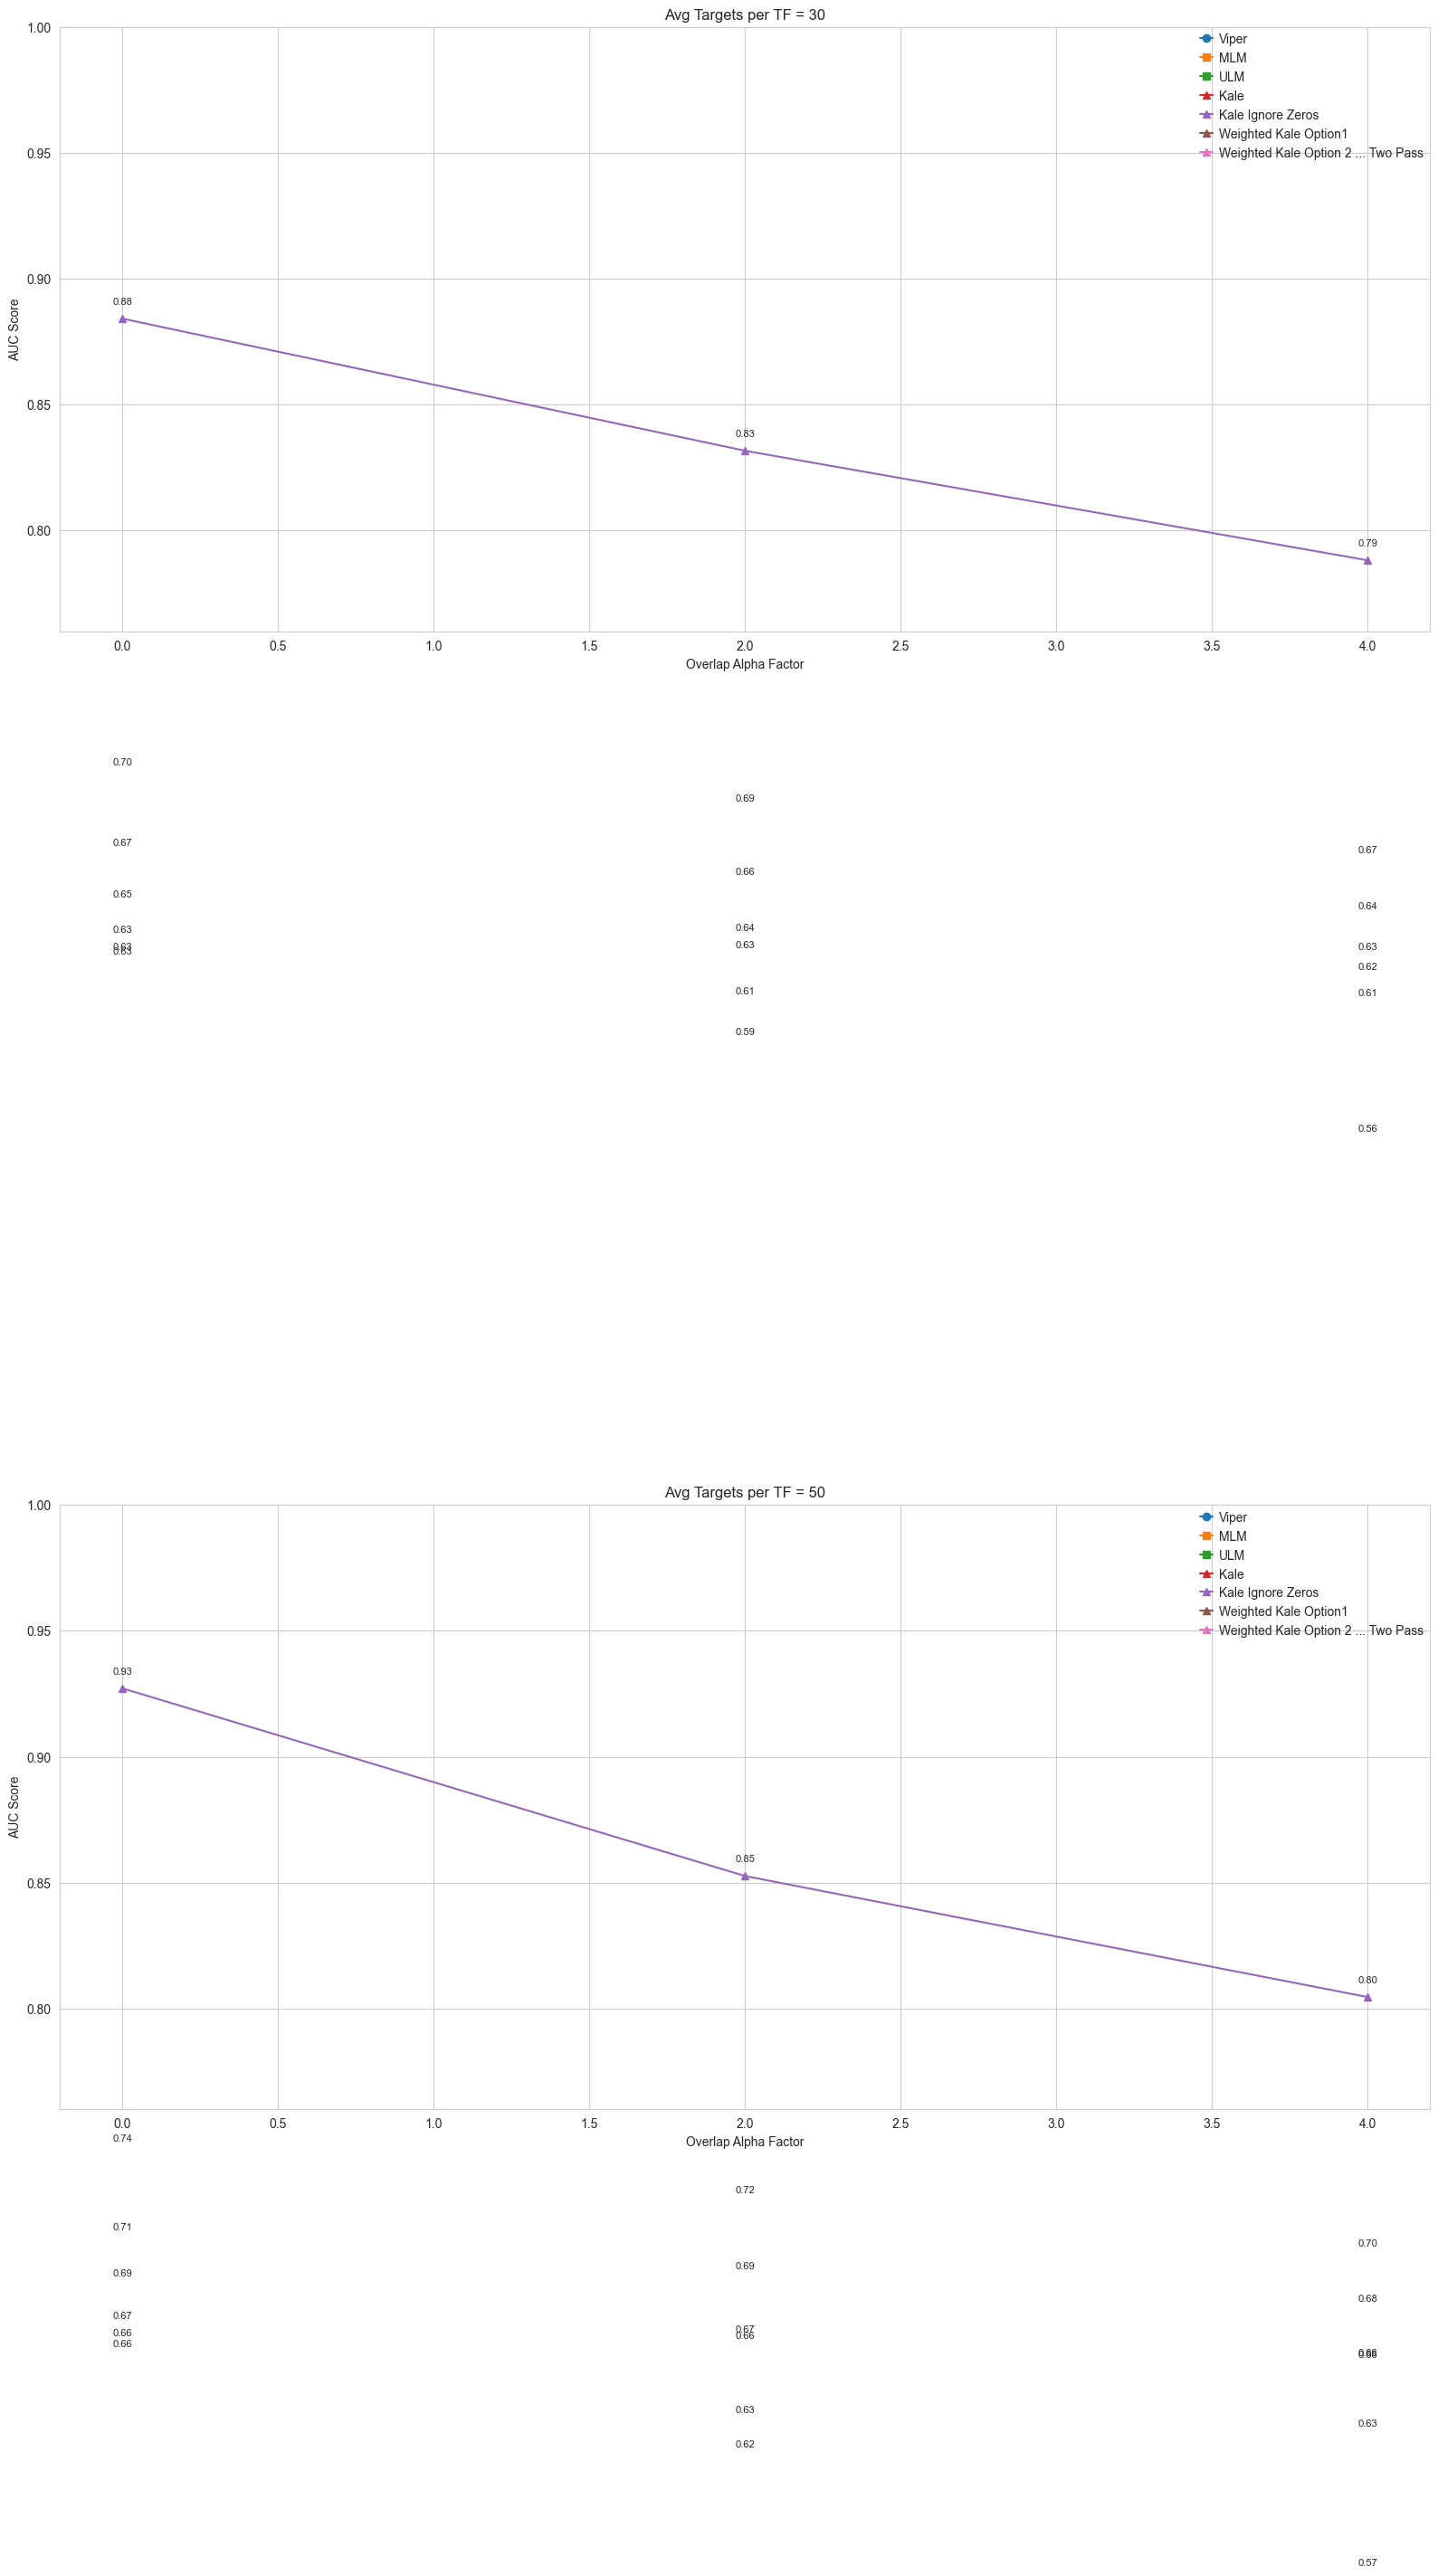

In [38]:
final_result = []
test_suite = []
prior_pairwise_overlap_stats = {}

alpha_values = [0, 2, 4]
average_targets = [30, 50]

for alpha in alpha_values:
    for avg_targets in average_targets:
        test_case = {
            "output_dir": "simulated_data/",
            "output_exp_file": "simulated_scRNASeq_data.tsv",
            "output_prior_file": "simulated_prior_data.tsv",
            "output_ground_truth_file": "simulated_ground_truth.tsv",
            "n_cells": 1000,
            "n_genes": 1000,
            "n_tfs": 100,
            "ground_truth_active_inactive_prob": 0.1,
            "overlap_alpha_factor": alpha,
            "average_number_of_targets_per_tf": avg_targets,
            "tf_effect_factor": 1.25,
            "missing_percentage": 50,
            "random_seed": 28,
            "distribution_type": "negative_binomial"
        }
        test_suite.append(test_case)

for i, test_case in enumerate(test_suite):
    with open("simulated_data/parameters.json", "w") as f:
        json.dump(test_case, f, indent=4)

    # 1. Generate simulated data
    print("\nGenerating simulated data for test case", i + 1)
    !uv run src/sim_data_generator_optimized.py simulated_data/parameters.json


    # 2. Run kale without
    print("\nRunning KALE for test case", i + 1)
    !uv run src/kale.py --gene_exp_file simulated_data/simulated_scRNASeq_data.tsv --prior_file simulated_data/simulated_prior_data.tsv --output_file simulated_data/_kale_scores.tsv --pvalue_output_file simulated_data/_kale_pvalues.tsv --ignore_zeros False --cores 8 --method rank_of_ranks --weighted False


    # 2.1 Run with a weighted option 1
    print("\nRunning KALE with weights for test case", i + 1)
    !uv run src/kale_archive.py --gene_exp_file simulated_data/simulated_scRNASeq_data.tsv --prior_file simulated_data/simulated_prior_data.tsv --output_file simulated_data/_kale_scores_weighted_option1.tsv --pvalue_output_file simulated_data/_kale_pvalues_weighted_option1.tsv --ignore_zeros False --cores 8 --method rank_of_ranks --weighted True

    # 2.2 Run with a weighted option 2
    print("\nRunning KALE with weights for test case", i + 1)
    !uv run src/kale.py --gene_exp_file simulated_data/simulated_scRNASeq_data.tsv --prior_file simulated_data/simulated_prior_data.tsv --output_file simulated_data/_kale_scores_weighted_option2.tsv --pvalue_output_file simulated_data/_kale_pvalues_weighted_option2.tsv --ignore_zeros False --cores 8 --method rank_of_ranks --weighted True


    # 3. Run kale with ignoring zeros
    print("\n\nRunning KALE with ignoring zeros for test case", i + 1)
    !uv run src/kale.py --gene_exp_file simulated_data/simulated_scRNASeq_data.tsv --prior_file simulated_data/simulated_prior_data.tsv --output_file simulated_data/_kale_scores_ignore_zeros.tsv --pvalue_output_file simulated_data/_kale_pvalues_ignore_zeros.tsv --ignore_zeros True --cores 8 --method rank_of_ranks


    # 4. Gene Expression data
    gene_exp_file = "simulated_data/simulated_scRNASeq_data.tsv"
    gene_exp = pd.read_csv(gene_exp_file, sep="\t", index_col=0)
    adata = sc.AnnData(gene_exp)
    # 1. Normalize (Corrects sequencing depth)
    sc.pp.normalize_total(adata, target_sum=1e4)
    # 2. Log transform (Stabilizes variance / makes data Gaussian-like)
    sc.pp.log1p(adata)
    # 3. Scale (Optional for ULM/MLM, Highly Recommended for VIPER)
    sc.pp.scale(adata, max_value=10)

    # 5. Prior Knowledge Network
    net_file = "simulated_data/simulated_prior_data.tsv"
    effect_map = {"upregulates-expression": 1, "downregulates-expression": -1}
    net = pd.read_csv(
        net_file,
        sep="\t",
        names=["source", "weight", "target"],
        usecols=[0, 1, 2],
        converters={"weight": effect_map.get}
    )[["source", "target", "weight"]]

    # 5.1 Pairwise Overlap Stats
    unique_tfs = net['source'].unique()
    group_size = 5
    overlap_coefficient_list = []
    for p in range(0, len(unique_tfs), group_size):
        current_tfs = unique_tfs[p:p + group_size]
        overlap_coefficient = []
        for j in range(len(current_tfs)):
            for k in range(j + 1, len(current_tfs)):
                targets_tf1 = set(net[net['source'] == current_tfs[j]]['target'])
                targets_tf2 = set(net[net['source'] == current_tfs[k]]['target'])
                intersection_targets = targets_tf1.intersection(targets_tf2)
                overlap_coefficient.append(len(intersection_targets) / min(len(targets_tf1), len(targets_tf2)))
        overlap_coefficient_list.append(overlap_coefficient)
    average_groupwise_overlap_coefficient = [sum(group) / len(group) for group in overlap_coefficient_list]
    prior_pairwise_overlap_stats[
        f"{test_case['overlap_alpha_factor']}_{test_case['average_number_of_targets_per_tf']}"] = overlap_coefficient_list

    # 6. Ground Truths
    ground_truths_file = "simulated_data/simulated_ground_truth.tsv"
    ground_truths = pd.read_csv(ground_truths_file, sep="\t", index_col=0)
    ground_truths = ground_truths.reset_index().rename(columns={"index": "Cell"})
    ground_truths = pd.melt(ground_truths, id_vars=["Cell"], var_name="TF", value_name="Value")
    ground_truths["Cell_TF"] = ground_truths["Cell"] + "_" + ground_truths["TF"]
    ground_truths = ground_truths[["Cell_TF", "Value"]]

    # 7. Run other methods
    print("\nRunning Viper and MLM...")
    methods_to_run = ["viper", "mlm", "ulm"]
    dc.mt.decouple(adata, net, tmin=1, methods=methods_to_run)

    # 8. Compute AUC for each method
    print("Computing AUC for each method...")
    methods_to_run.append("kale")
    methods_to_run.append("weighted_kale_option1")
    methods_to_run.append("weighted_kale_option2")
    methods_to_run.append("kale_ignore_zeros")

    for method in methods_to_run:
        if method == "kale":
            method_scores = pd.read_csv("simulated_data/_kale_scores.tsv", sep="\t", index_col=0)
        elif method == "kale_ignore_zeros":
            method_scores = pd.read_csv("simulated_data/_kale_scores_ignore_zeros.tsv", sep="\t", index_col=0)
        elif method == "weighted_kale_option1":
            method_scores = pd.read_csv("simulated_data/_kale_scores_weighted_option1.tsv", sep="\t", index_col=0)
        elif method == "weighted_kale_option2":
            method_scores = pd.read_csv("simulated_data/_kale_scores_weighted_option2.tsv", sep="\t", index_col=0)
        else:
            method_scores = adata.obsm[f"score_{method}"]

        ##### Missing Check #####
        missing_count = method_scores.isnull().sum().sum()
        if missing_count > 0:
            print("*" * 150 + " ," + method)
            print(f"Warning: {missing_count} missing values found in {method} scores. Filling with 0.")
            method_scores = method_scores.fillna(0)
            # Find row and column indexes with missing values
            missing_rows, missing_cols = np.where(method_scores.isnull())
            for row, col in zip(missing_rows, missing_cols):
                print(f"Missing value at row {method_scores.index[row]}, column {method_scores.columns[col]}")
            print("*" * 150)
        #########################

        # Melt the DataFrame to long format
        scores_out = method_scores.reset_index().rename(columns={"index": "Cell"})
        scores_out = pd.melt(scores_out, id_vars=["Cell"], var_name="TF", value_name="Value")
        scores_out["Cell_TF"] = scores_out["Cell"] + "_" + scores_out["TF"]
        scores_out = scores_out[["Cell_TF", "Value"]]

        # Merge with ground truths
        scores_merged = scores_out.merge(ground_truths, on="Cell_TF", suffixes=("_pred", "_true"))

        # Sort by Cell_TF to ensure consistent ordering
        scores_merged = scores_merged.sort_values(by="Value_pred", ascending=False)
        scores_merged['y_true'] = (scores_merged['Value_true'] == 1.0).astype(int)

        # Compute ROC curve and AUC
        fpr, tpr, _ = roc_curve(scores_merged['y_true'], scores_merged['Value_pred'])
        roc_auc = auc(fpr, tpr)

        # collect AUC results
        test_case["auc_" + method] = roc_auc

    final_result.append(test_case)

# 8. Save final results to a CSV file
final_result_df = pd.DataFrame(final_result)
final_result_df.drop(
    ['output_dir', 'output_exp_file', 'output_prior_file', 'output_ground_truth_file', 'distribution_type'], axis=1,
    inplace=True)
final_result_df.to_csv("simulated_data/simulation_test_suite_results_with_overlap_k_5_overlap_coefficient.tsv",
                       index=False, sep="\t")

# 9. Save prior pairwise overlap stats in tsv
overlap_stats_df = pd.DataFrame(prior_pairwise_overlap_stats)
overlap_stats_df.to_csv("simulated_data/pairwise_overlap_histogram_k_5_overlap_coefficient.tsv", index=False, sep="\t")



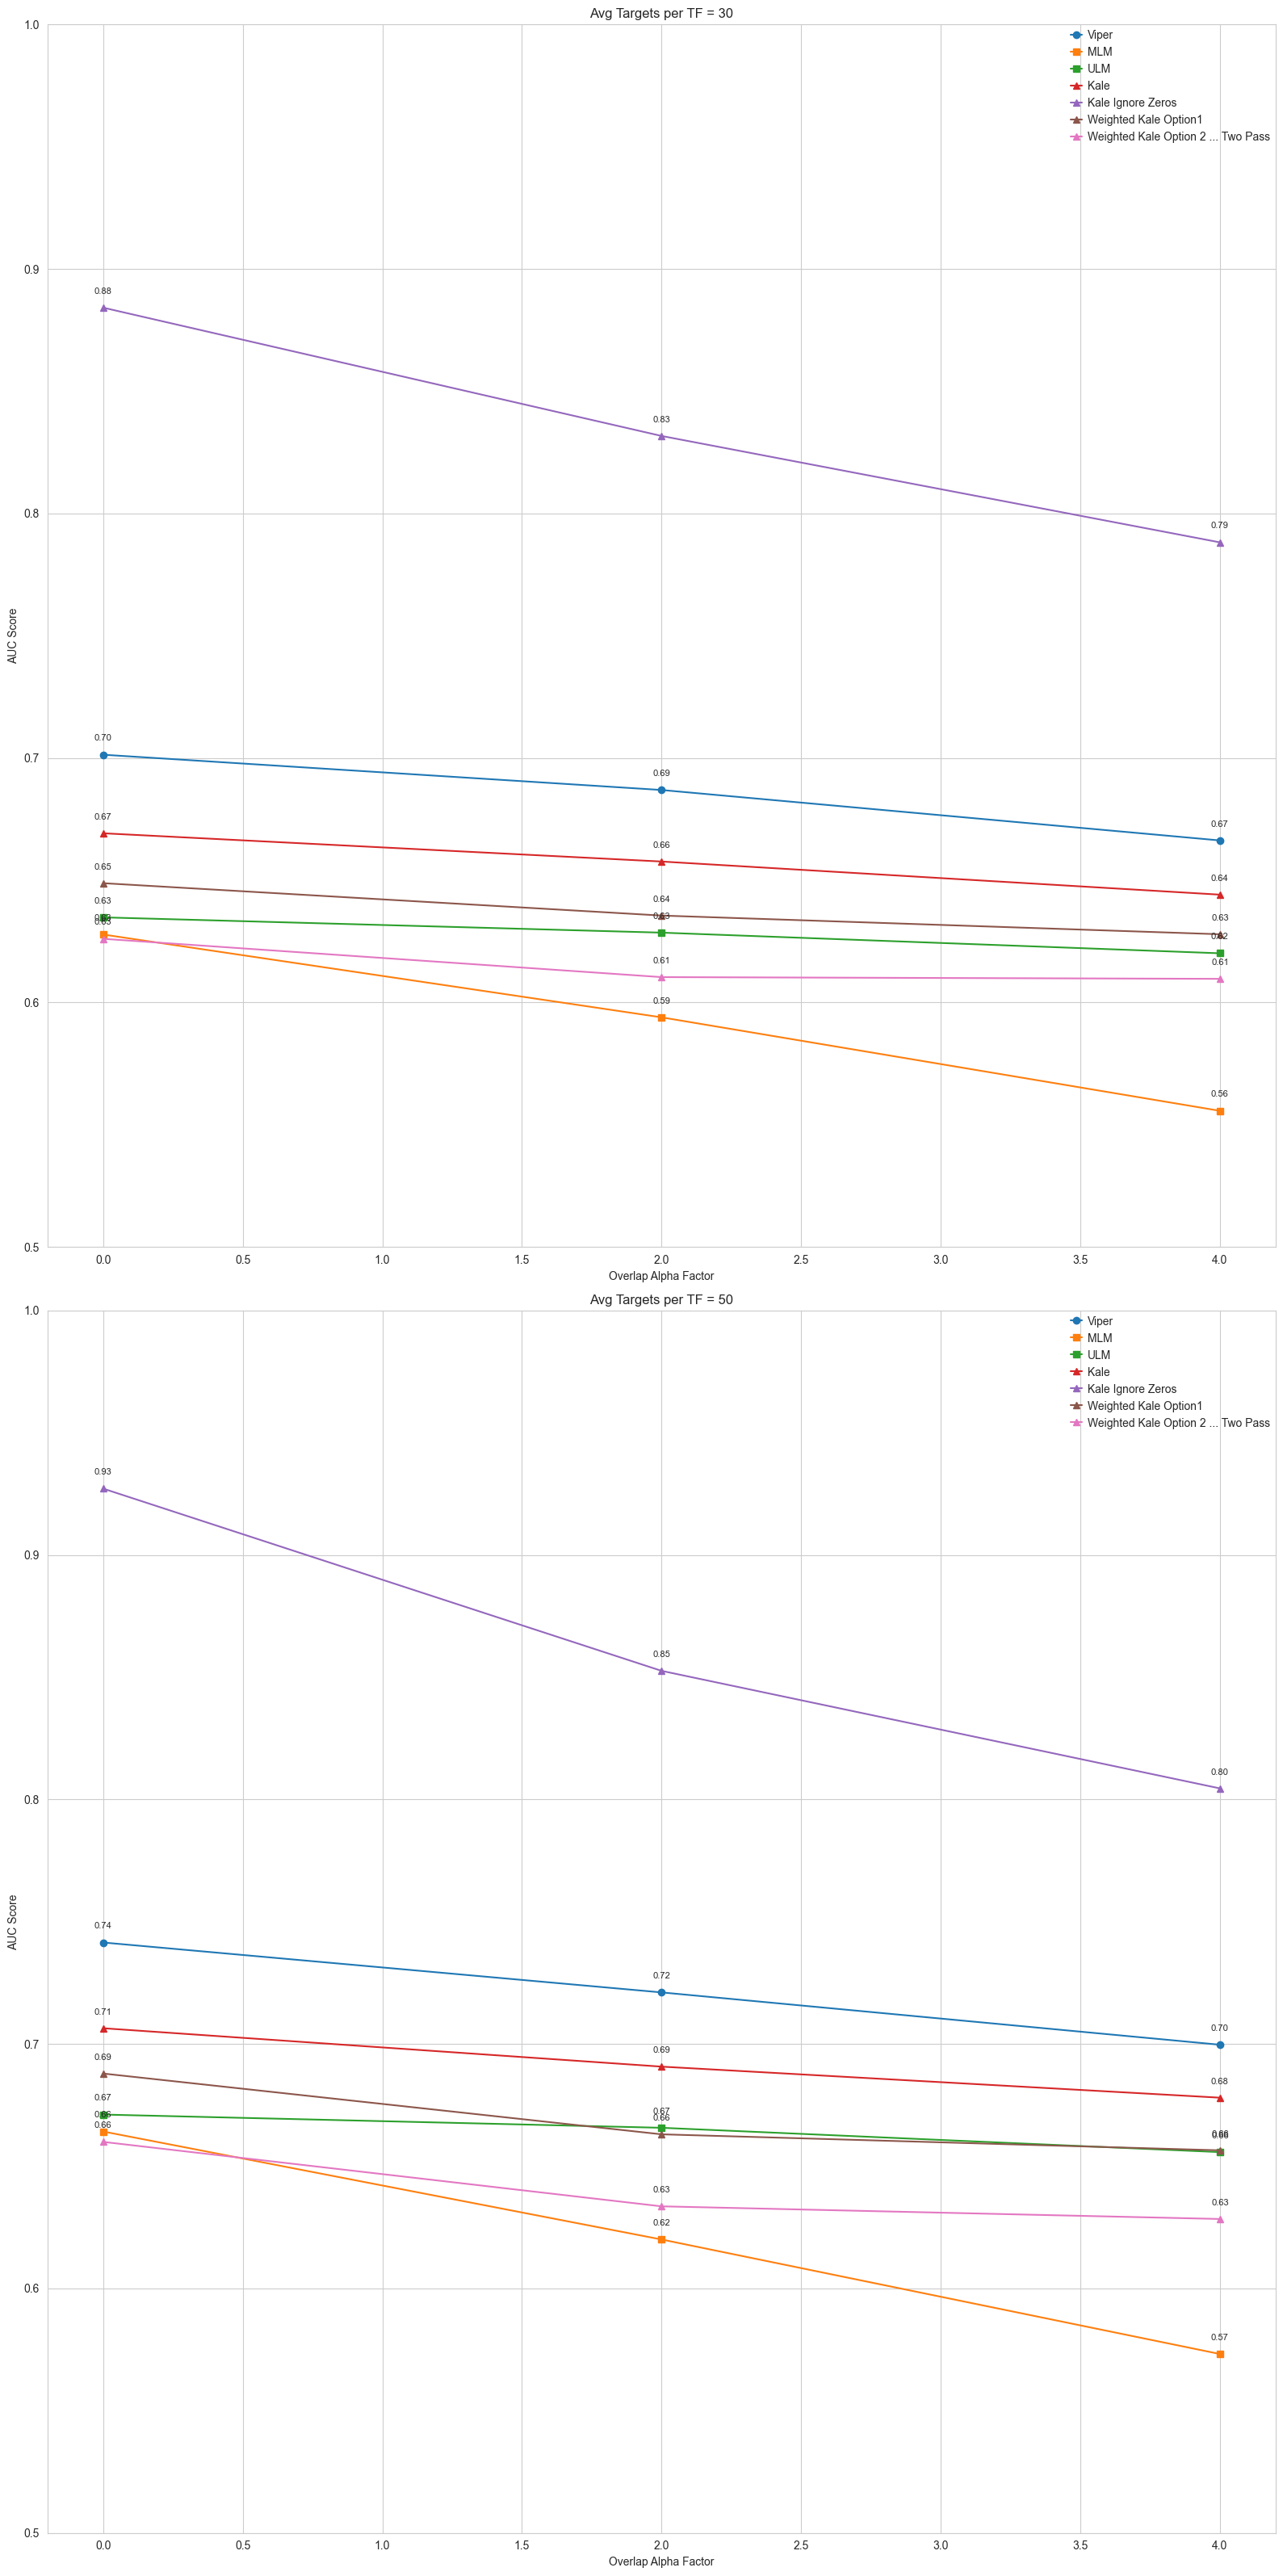

In [39]:

# Load data
final_result_df = pd.read_csv(
    "simulated_data/simulation_test_suite_results_with_overlap_k_5_overlap_coefficient.tsv",
    sep="\t"
)
# Unique target counts
unique_targets = sorted(final_result_df['average_number_of_targets_per_tf'].unique())

# Setup figure
fig, axes = plt.subplots(len(unique_targets), 1, figsize=(16, 16 * len(unique_targets)))
if len(unique_targets) == 1:
    axes = [axes]

# Plot
for i, n_targets in enumerate(unique_targets):
    ax = axes[i]
    n_targets_results = final_result_df[final_result_df['average_number_of_targets_per_tf'] == n_targets]

    alpha_values = sorted(n_targets_results['overlap_alpha_factor'].unique())

    ax.plot(alpha_values, n_targets_results['auc_viper'], marker='o', label='Viper')
    ax.plot(alpha_values, n_targets_results['auc_mlm'], marker='s', label='MLM')
    ax.plot(alpha_values, n_targets_results['auc_ulm'], marker='s', label='ULM')
    ax.plot(alpha_values, n_targets_results['auc_kale'], marker='^', label='Kale')
    ax.plot(alpha_values, n_targets_results['auc_kale_ignore_zeros'], marker='^', label='Kale Ignore Zeros')
    ax.plot(alpha_values, n_targets_results['auc_weighted_kale_option1'], marker='^', label='Weighted Kale Option1')
    ax.plot(alpha_values, n_targets_results['auc_weighted_kale_option2'], marker='^',
            label='Weighted Kale Option 2 ... Two Pass')

    for col, label in [('auc_viper', 'Viper AUC'),
                       ('auc_mlm', 'MLM AUC'),
                       ('auc_ulm', 'ULM AUC'),
                       ('auc_kale', 'Kale AUC'),
                       ('auc_kale_ignore_zeros', 'Kale AUC Ignore Zeros'),
                       ('auc_weighted_kale_option1', 'Weighted Kale AUC option1'),
                       ('auc_weighted_kale_option2', 'Weighted Kale AUC option Two pass')]:
        for x, y in zip(alpha_values, n_targets_results[col]):
            ax.text(x, y + 0.005, f'{y:.2f}', ha='center', va='bottom', fontsize=8)

    ax.set_xlabel('Overlap Alpha Factor')
    ax.set_ylabel('AUC Score')
    ax.set_title(f'Avg Targets per TF = {n_targets}')
    ax.set_ylim(0.5, 1)
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()

## 70 percent missing

In [40]:
final_result = []
test_suite = []
prior_pairwise_overlap_stats = {}

alpha_values = [0, 2, 4]
average_targets = [30, 50]

for alpha in alpha_values:
    for avg_targets in average_targets:
        test_case = {
            "output_dir": "simulated_data/",
            "output_exp_file": "simulated_scRNASeq_data.tsv",
            "output_prior_file": "simulated_prior_data.tsv",
            "output_ground_truth_file": "simulated_ground_truth.tsv",
            "n_cells": 1000,
            "n_genes": 1000,
            "n_tfs": 100,
            "ground_truth_active_inactive_prob": 0.1,
            "overlap_alpha_factor": alpha,
            "average_number_of_targets_per_tf": avg_targets,
            "tf_effect_factor": 1.25,
            "missing_percentage": 70,
            "random_seed": 8,
            "distribution_type": "negative_binomial"
        }
        test_suite.append(test_case)

for i, test_case in enumerate(test_suite):
    with open("simulated_data/parameters.json", "w") as f:
        json.dump(test_case, f, indent=4)

    # 1. Generate simulated data
    print("\nGenerating simulated data for test case", i + 1)
    !uv run src/sim_data_generator_optimized.py simulated_data/parameters.json


    # 2. Run kale without
    print("\nRunning KALE for test case", i + 1)
    !uv run src/kale.py --gene_exp_file simulated_data/simulated_scRNASeq_data.tsv --prior_file simulated_data/simulated_prior_data.tsv --output_file simulated_data/_kale_scores.tsv --pvalue_output_file simulated_data/_kale_pvalues.tsv --ignore_zeros False --cores 8 --method rank_of_ranks --weighted False


    # 2.1 Run with a weighted option 1
    print("\nRunning KALE with weights for test case", i + 1)
    !uv run src/kale_archive.py --gene_exp_file simulated_data/simulated_scRNASeq_data.tsv --prior_file simulated_data/simulated_prior_data.tsv --output_file simulated_data/_kale_scores_weighted_option1.tsv --pvalue_output_file simulated_data/_kale_pvalues_weighted_option1.tsv --ignore_zeros False --cores 8 --method rank_of_ranks --weighted True

    # 2.2 Run with a weighted option 2
    print("\nRunning KALE with weights for test case", i + 1)
    !uv run src/kale.py --gene_exp_file simulated_data/simulated_scRNASeq_data.tsv --prior_file simulated_data/simulated_prior_data.tsv --output_file simulated_data/_kale_scores_weighted_option2.tsv --pvalue_output_file simulated_data/_kale_pvalues_weighted_option2.tsv --ignore_zeros False --cores 8 --method rank_of_ranks --weighted True


    # 3. Run kale with ignoring zeros
    print("\n\nRunning KALE with ignoring zeros for test case", i + 1)
    !uv run src/kale.py --gene_exp_file simulated_data/simulated_scRNASeq_data.tsv --prior_file simulated_data/simulated_prior_data.tsv --output_file simulated_data/_kale_scores_ignore_zeros.tsv --pvalue_output_file simulated_data/_kale_pvalues_ignore_zeros.tsv --ignore_zeros True --cores 8 --method rank_of_ranks


    # 4. Gene Expression data
    gene_exp_file = "simulated_data/simulated_scRNASeq_data.tsv"
    gene_exp = pd.read_csv(gene_exp_file, sep="\t", index_col=0)
    adata = sc.AnnData(gene_exp)
    # 1. Normalize (Corrects sequencing depth)
    sc.pp.normalize_total(adata, target_sum=1e4)
    # 2. Log transform (Stabilizes variance / makes data Gaussian-like)
    sc.pp.log1p(adata)
    # 3. Scale (Optional for ULM/MLM, Highly Recommended for VIPER)
    sc.pp.scale(adata, max_value=10)

    # 5. Prior Knowledge Network
    net_file = "simulated_data/simulated_prior_data.tsv"
    effect_map = {"upregulates-expression": 1, "downregulates-expression": -1}
    net = pd.read_csv(
        net_file,
        sep="\t",
        names=["source", "weight", "target"],
        usecols=[0, 1, 2],
        converters={"weight": effect_map.get}
    )[["source", "target", "weight"]]

    # 5.1 Pairwise Overlap Stats
    unique_tfs = net['source'].unique()
    group_size = 5
    overlap_coefficient_list = []
    for p in range(0, len(unique_tfs), group_size):
        current_tfs = unique_tfs[p:p + group_size]
        overlap_coefficient = []
        for j in range(len(current_tfs)):
            for k in range(j + 1, len(current_tfs)):
                targets_tf1 = set(net[net['source'] == current_tfs[j]]['target'])
                targets_tf2 = set(net[net['source'] == current_tfs[k]]['target'])
                intersection_targets = targets_tf1.intersection(targets_tf2)
                overlap_coefficient.append(len(intersection_targets) / min(len(targets_tf1), len(targets_tf2)))
        overlap_coefficient_list.append(overlap_coefficient)
    average_groupwise_overlap_coefficient = [sum(group) / len(group) for group in overlap_coefficient_list]
    prior_pairwise_overlap_stats[
        f"{test_case['overlap_alpha_factor']}_{test_case['average_number_of_targets_per_tf']}"] = overlap_coefficient_list

    # 6. Ground Truths
    ground_truths_file = "simulated_data/simulated_ground_truth.tsv"
    ground_truths = pd.read_csv(ground_truths_file, sep="\t", index_col=0)
    ground_truths = ground_truths.reset_index().rename(columns={"index": "Cell"})
    ground_truths = pd.melt(ground_truths, id_vars=["Cell"], var_name="TF", value_name="Value")
    ground_truths["Cell_TF"] = ground_truths["Cell"] + "_" + ground_truths["TF"]
    ground_truths = ground_truths[["Cell_TF", "Value"]]

    # 7. Run other methods
    print("\nRunning Viper and MLM...")
    methods_to_run = ["viper", "mlm", "ulm"]
    dc.mt.decouple(adata, net, tmin=1, methods=methods_to_run)

    # 8. Compute AUC for each method
    print("Computing AUC for each method...")
    methods_to_run.append("kale")
    methods_to_run.append("weighted_kale_option1")
    methods_to_run.append("weighted_kale_option2")
    methods_to_run.append("kale_ignore_zeros")

    for method in methods_to_run:
        if method == "kale":
            method_scores = pd.read_csv("simulated_data/_kale_scores.tsv", sep="\t", index_col=0)
        elif method == "kale_ignore_zeros":
            method_scores = pd.read_csv("simulated_data/_kale_scores_ignore_zeros.tsv", sep="\t", index_col=0)
        elif method == "weighted_kale_option1":
            method_scores = pd.read_csv("simulated_data/_kale_scores_weighted_option1.tsv", sep="\t", index_col=0)
        elif method == "weighted_kale_option2":
            method_scores = pd.read_csv("simulated_data/_kale_scores_weighted_option2.tsv", sep="\t", index_col=0)
        else:
            method_scores = adata.obsm[f"score_{method}"]

        ##### Missing Check #####
        missing_count = method_scores.isnull().sum().sum()
        if missing_count > 0:
            print("*" * 150 + " ," + method)
            print(f"Warning: {missing_count} missing values found in {method} scores. Filling with 0.")
            method_scores = method_scores.fillna(0)
            # Find row and column indexes with missing values
            missing_rows, missing_cols = np.where(method_scores.isnull())
            for row, col in zip(missing_rows, missing_cols):
                print(f"Missing value at row {method_scores.index[row]}, column {method_scores.columns[col]}")
            print("*" * 150)
        #########################

        # Melt the DataFrame to long format
        scores_out = method_scores.reset_index().rename(columns={"index": "Cell"})
        scores_out = pd.melt(scores_out, id_vars=["Cell"], var_name="TF", value_name="Value")
        scores_out["Cell_TF"] = scores_out["Cell"] + "_" + scores_out["TF"]
        scores_out = scores_out[["Cell_TF", "Value"]]

        # Merge with ground truths
        scores_merged = scores_out.merge(ground_truths, on="Cell_TF", suffixes=("_pred", "_true"))

        # Sort by Cell_TF to ensure consistent ordering
        scores_merged = scores_merged.sort_values(by="Value_pred", ascending=False)
        scores_merged['y_true'] = (scores_merged['Value_true'] == 1.0).astype(int)

        # Compute ROC curve and AUC
        fpr, tpr, _ = roc_curve(scores_merged['y_true'], scores_merged['Value_pred'])
        roc_auc = auc(fpr, tpr)

        # collect AUC results
        test_case["auc_" + method] = roc_auc

    final_result.append(test_case)

# 8. Save final results to a CSV file
final_result_df = pd.DataFrame(final_result)
final_result_df.drop(
    ['output_dir', 'output_exp_file', 'output_prior_file', 'output_ground_truth_file', 'distribution_type'], axis=1,
    inplace=True)
final_result_df.to_csv("simulated_data/simulation_test_suite_results_with_overlap_k_5_overlap_coefficient.tsv",
                       index=False, sep="\t")

# 9. Save prior pairwise overlap stats in tsv
overlap_stats_df = pd.DataFrame(prior_pairwise_overlap_stats)
overlap_stats_df.to_csv("simulated_data/pairwise_overlap_histogram_k_5_overlap_coefficient.tsv", index=False, sep="\t")




Generating simulated data for test case 1
{'output_dir': 'simulated_data/', 'output_exp_file': 'simulated_scRNASeq_data.tsv', 'output_prior_file': 'simulated_prior_data.tsv', 'output_ground_truth_file': 'simulated_ground_truth.tsv', 'n_cells': 1000, 'n_genes': 1000, 'n_tfs': 100, 'ground_truth_active_inactive_prob': 0.1, 'overlap_alpha_factor': 0, 'average_number_of_targets_per_tf': 30, 'tf_effect_factor': 1.25, 'missing_percentage': 70, 'random_seed': 8, 'distribution_type': 'negative_binomial'}
Generating prior data (Poisson targets)...
Generating gene expression data...
Generating gene expression data...
Zero percentage before dropout: 0.1577
Zero percentage after dropout: 69.9807
Wrote prior to simulated_prior_data.tsv
Wrote ground truth to simulated_ground_truth.tsv
Wrote gene expression to simulated_scRNASeq_data.tsv

Running KALE for test case 1
Preprocessing gene expression data...
Using raw gene expression as input for per-cell ranking...
Starting TF activity using 8 cores.
R

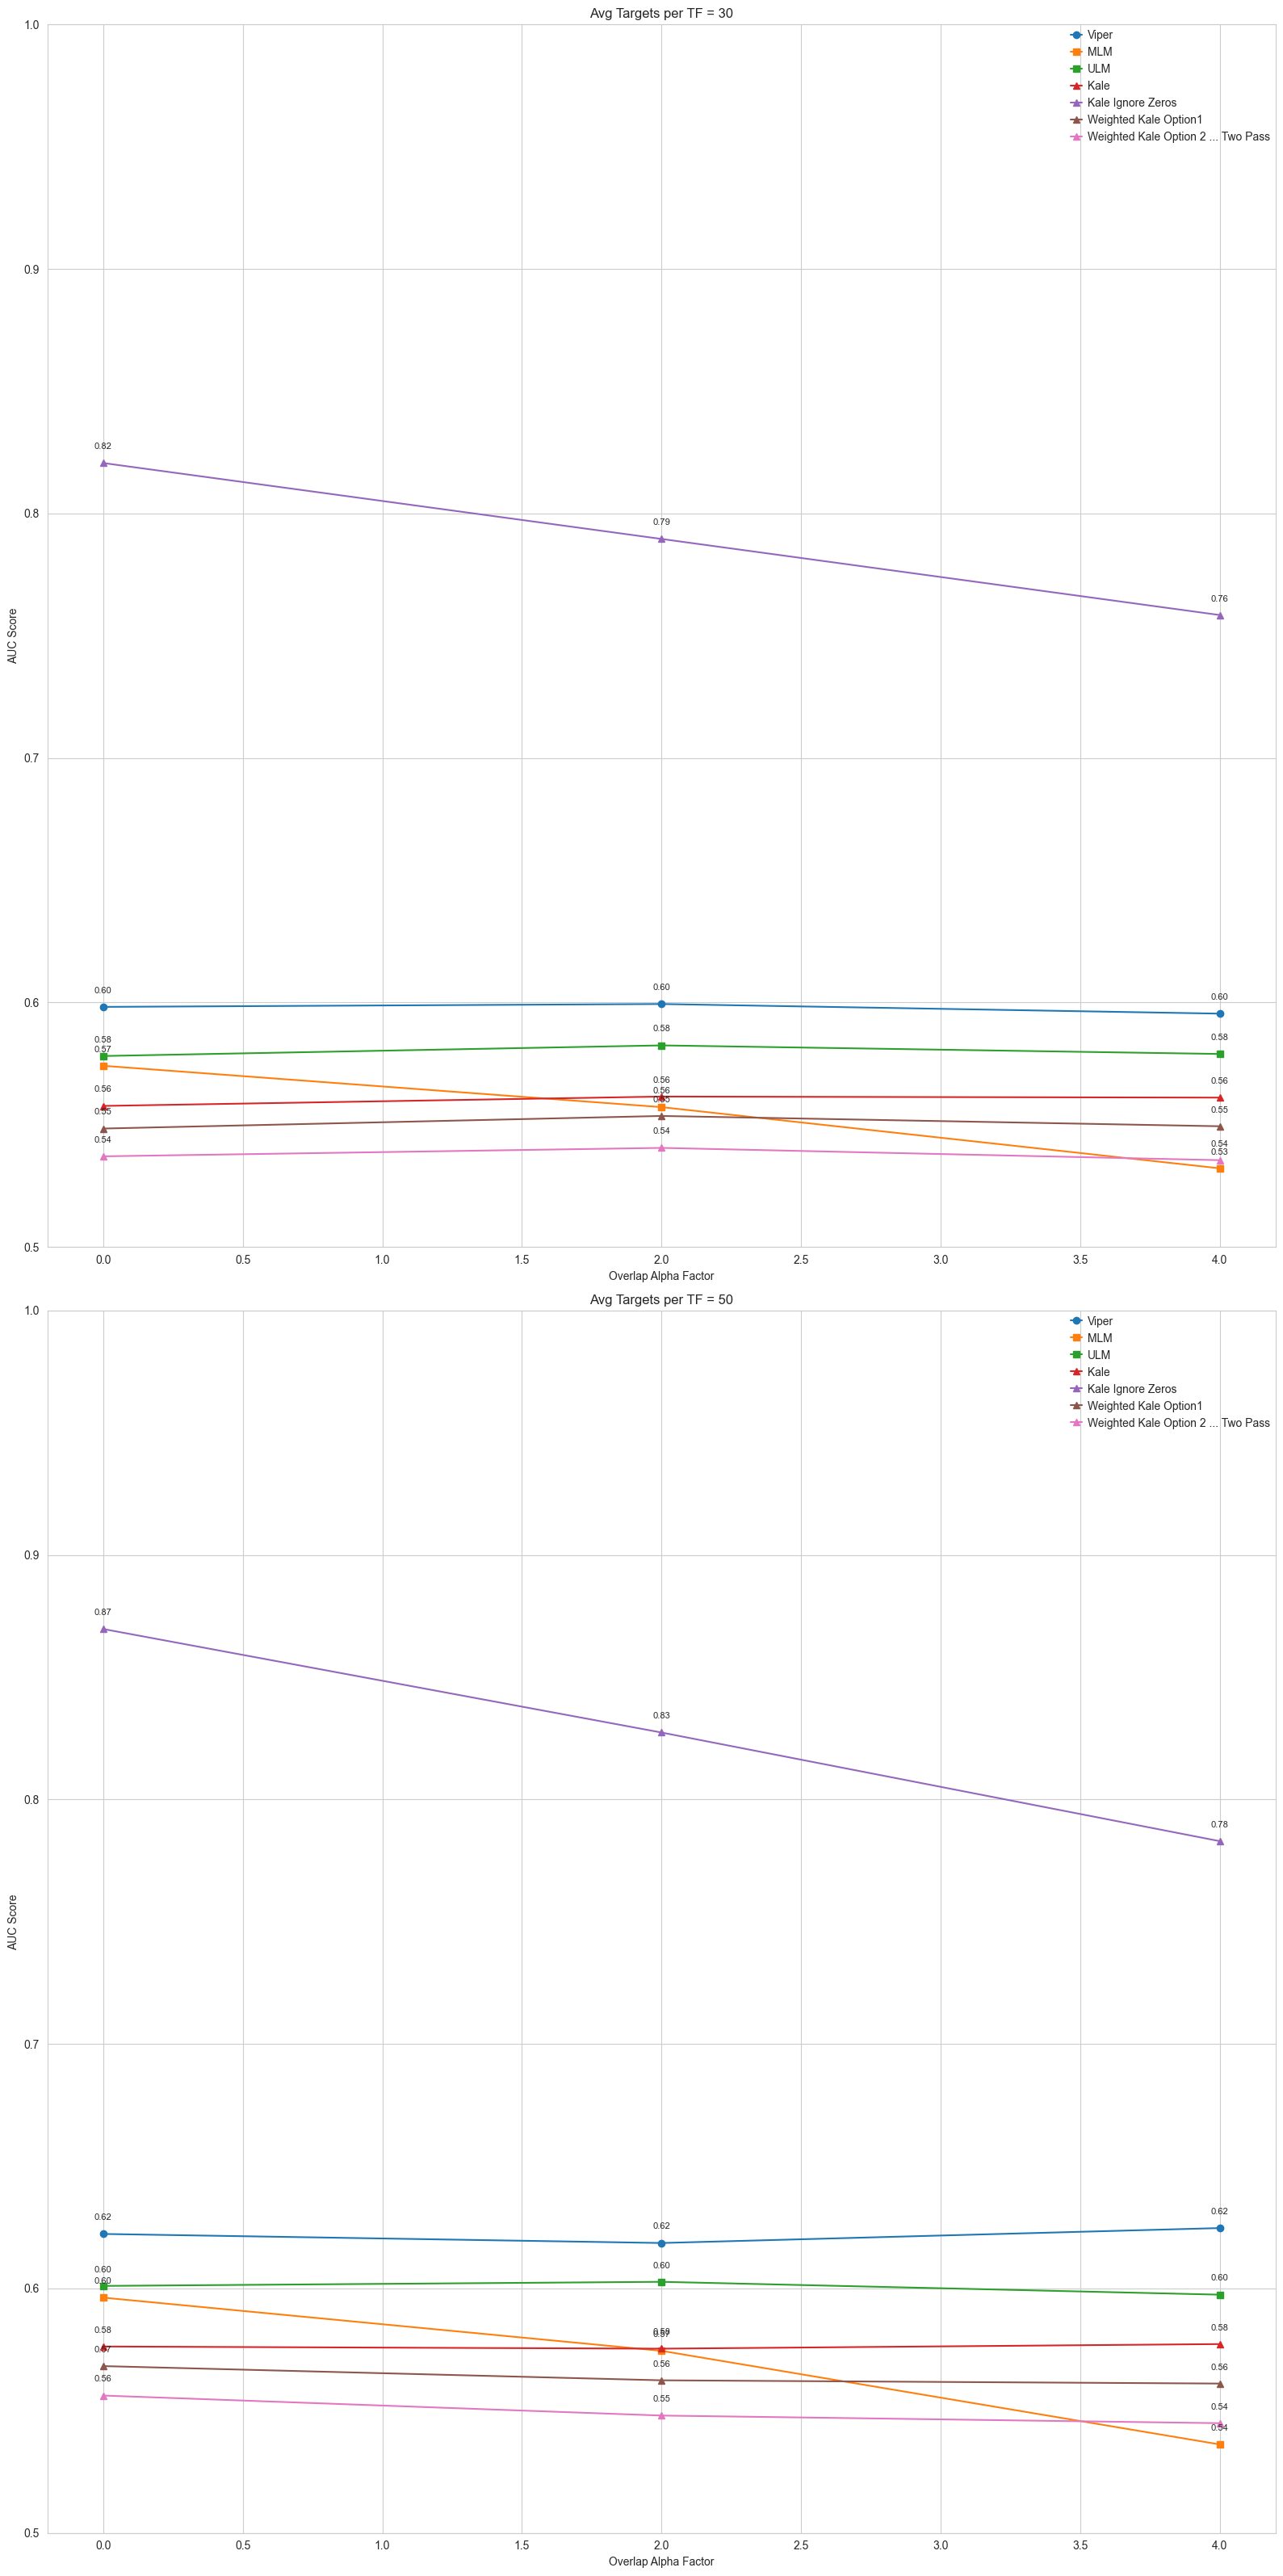

In [41]:
# Load data
final_result_df = pd.read_csv(
    "simulated_data/simulation_test_suite_results_with_overlap_k_5_overlap_coefficient.tsv",
    sep="\t"
)
# Unique target counts
unique_targets = sorted(final_result_df['average_number_of_targets_per_tf'].unique())

# Setup figure
fig, axes = plt.subplots(len(unique_targets), 1, figsize=(16, 16 * len(unique_targets)))
if len(unique_targets) == 1:
    axes = [axes]

# Plot
for i, n_targets in enumerate(unique_targets):
    ax = axes[i]
    n_targets_results = final_result_df[final_result_df['average_number_of_targets_per_tf'] == n_targets]

    alpha_values = sorted(n_targets_results['overlap_alpha_factor'].unique())

    ax.plot(alpha_values, n_targets_results['auc_viper'], marker='o', label='Viper')
    ax.plot(alpha_values, n_targets_results['auc_mlm'], marker='s', label='MLM')
    ax.plot(alpha_values, n_targets_results['auc_ulm'], marker='s', label='ULM')
    ax.plot(alpha_values, n_targets_results['auc_kale'], marker='^', label='Kale')
    ax.plot(alpha_values, n_targets_results['auc_kale_ignore_zeros'], marker='^', label='Kale Ignore Zeros')
    ax.plot(alpha_values, n_targets_results['auc_weighted_kale_option1'], marker='^', label='Weighted Kale Option1')
    ax.plot(alpha_values, n_targets_results['auc_weighted_kale_option2'], marker='^',
            label='Weighted Kale Option 2 ... Two Pass')

    for col, label in [('auc_viper', 'Viper AUC'),
                       ('auc_mlm', 'MLM AUC'),
                       ('auc_ulm', 'ULM AUC'),
                       ('auc_kale', 'Kale AUC'),
                       ('auc_kale_ignore_zeros', 'Kale AUC Ignore Zeros'),
                       ('auc_weighted_kale_option1', 'Weighted Kale AUC option1'),
                       ('auc_weighted_kale_option2', 'Weighted Kale AUC option Two pass')]:
        for x, y in zip(alpha_values, n_targets_results[col]):
            ax.text(x, y + 0.005, f'{y:.2f}', ha='center', va='bottom', fontsize=8)

    ax.set_xlabel('Overlap Alpha Factor')
    ax.set_ylabel('AUC Score')
    ax.set_title(f'Avg Targets per TF = {n_targets}')
    ax.set_ylim(0.5, 1)
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()

# END Parameters test suite

In [26]:
final_result_df

,n_cells,n_genes,n_tfs,ground_truth_active_inactive_prob,overlap_alpha_factor,average_number_of_targets_per_tf,tf_effect_factor,missing_percentage,random_seed,auc_viper,auc_mlm,auc_ulm,auc_kale,auc_weighted_kale_option1,auc_weighted_kale_option2,auc_kale_ignore_zeros
0,1000,1000,100,0.1,0,30,1.25,50,28,0.614553,0.608875,0.614113,0.669219,0.648808,0.626054,0.669219
1,1000,1000,100,0.1,2,30,1.25,50,28,0.606992,0.576778,0.607264,0.657666,0.635565,0.610386,0.657666


In [7]:
overlap_stats_df

,0_30,0_50,2_30,2_50,4_30,4_50
0,"[0.0, 0.13333333333333333, 0.0, 0.028571428571...","[0.05357142857142857, 0.11764705882352941, 0.0...","[0.7222222222222222, 0.6333333333333333, 0.555...","[0.6785714285714286, 0.6764705882352942, 0.647...","[0.9444444444444444, 0.9, 1.0, 0.9428571428571...","[0.9464285714285714, 0.9705882352941176, 0.882..."
1,"[0.0, 0.0625, 0.08695652173913043, 0.04, 0.083...","[0.03508771929824561, 0.07142857142857142, 0.0...","[0.75, 0.71875, 0.8695652173913043, 0.88, 0.54...","[0.7894736842105263, 0.6190476190476191, 0.576...","[1.0, 0.9375, 1.0, 0.96, 0.9166666666666666, 0...","[0.9649122807017544, 0.9523809523809523, 0.884..."
2,"[0.0, 0.09523809523809523, 0.0, 0.047619047619...","[0.05263157894736842, 0.06818181818181818, 0.0...","[0.5714285714285714, 0.47619047619047616, 0.52...","[0.5789473684210527, 0.6136363636363636, 0.631...","[0.9523809523809523, 0.7619047619047619, 0.904...","[0.8947368421052632, 0.8863636363636364, 0.894..."
3,"[0.0, 0.0, 0.04878048780487805, 0.037037037037...","[0.07936507936507936, 0.05660377358490566, 0.0...","[0.53125, 0.65, 0.7073170731707317, 0.62962962...","[0.7301587301587301, 0.6415094339622641, 0.697...","[0.9375, 0.95, 0.8780487804878049, 0.962962962...","[0.8888888888888888, 0.9622641509433962, 0.976..."
4,"[0.06060606060606061, 0.08, 0.0, 0.0, 0.12, 0....","[0.043478260869565216, 0.08695652173913043, 0....","[0.5151515151515151, 0.56, 0.6060606060606061,...","[0.5, 0.5652173913043478, 0.6304347826086957, ...","[0.8181818181818182, 0.92, 0.8787878787878788,...","[0.8695652173913043, 0.8913043478260869, 0.956..."
5,"[0.08, 0.0, 0.04, 0.045454545454545456, 0.0303...","[0.08928571428571429, 0.09090909090909091, 0.0...","[0.68, 0.6, 0.4, 0.45454545454545453, 0.606060...","[0.6071428571428571, 0.6136363636363636, 0.607...","[1.0, 0.96, 0.88, 0.9545454545454546, 0.939393...","[0.8928571428571429, 0.8863636363636364, 0.964..."
6,"[0.03333333333333333, 0.06666666666666667, 0.0...","[0.047619047619047616, 0.05128205128205128, 0....","[0.4666666666666667, 0.5666666666666667, 0.571...","[0.5952380952380952, 0.6666666666666666, 0.604...","[0.8666666666666667, 0.9666666666666667, 0.892...","[0.8809523809523809, 0.8717948717948718, 0.854..."
7,"[0.034482758620689655, 0.0, 0.0344827586206896...","[0.08333333333333333, 0.058823529411764705, 0....","[0.5862068965517241, 0.6206896551724138, 0.482...","[0.5208333333333334, 0.5490196078431373, 0.632...","[0.896551724137931, 0.8620689655172413, 0.8275...","[0.9166666666666666, 0.9019607843137255, 0.959..."
8,"[0.0, 0.0, 0.0, 0.037037037037037035, 0.038461...","[0.07547169811320754, 0.06521739130434782, 0.1...","[0.5666666666666667, 0.5769230769230769, 0.766...","[0.5849056603773585, 0.5869565217391305, 0.574...","[0.9, 0.9615384615384616, 0.9666666666666667, ...","[0.8679245283018868, 0.9130434782608695, 0.888..."
9,"[0.06896551724137931, 0.05263157894736842, 0.0...","[0.06818181818181818, 0.13636363636363635, 0.0...","[0.7241379310344828, 0.47368421052631576, 0.51...","[0.4772727272727273, 0.5, 0.5909090909090909, ...","[0.8620689655172413, 0.9473684210526315, 0.851...","[0.8863636363636364, 0.8409090909090909, 0.886..."


In [9]:
import numpy as np

average_pairwise_overlap_histogram = overlap_stats_df.apply(
    lambda col: col.map(lambda x: eval(x) if isinstance(x, str) else x)
)
average_pairwise_overlap_histogram = average_pairwise_overlap_histogram.apply(
    lambda col: col.map(lambda x: np.mean(x) if isinstance(x, (list, np.ndarray)) else x)
)
average_pairwise_overlap_histogram = average_pairwise_overlap_histogram.astype(float)
average_pairwise_overlap_histogram

,0_30,0_50,2_30,2_50,4_30,4_50
0,0.038413,0.065118,0.660000,0.650722,0.931323,0.922350
1,0.039975,0.060783,0.608976,0.649264,0.892228,0.943838
2,0.054886,0.055855,0.630083,0.573174,0.933333,0.867455
3,0.029114,0.057850,0.597259,0.638863,0.899911,0.936380
4,0.048693,0.061703,0.583827,0.577755,0.913506,0.904041
5,0.039381,0.047300,0.564645,0.604880,0.956186,0.927701
6,0.023594,0.053299,0.551375,0.619547,0.895684,0.855947
7,0.037364,0.062989,0.580240,0.567303,0.892853,0.926999
8,0.026125,0.053762,0.564644,0.586554,0.898291,0.913813
9,0.033797,0.069396,0.582221,0.578179,0.897313,0.906602


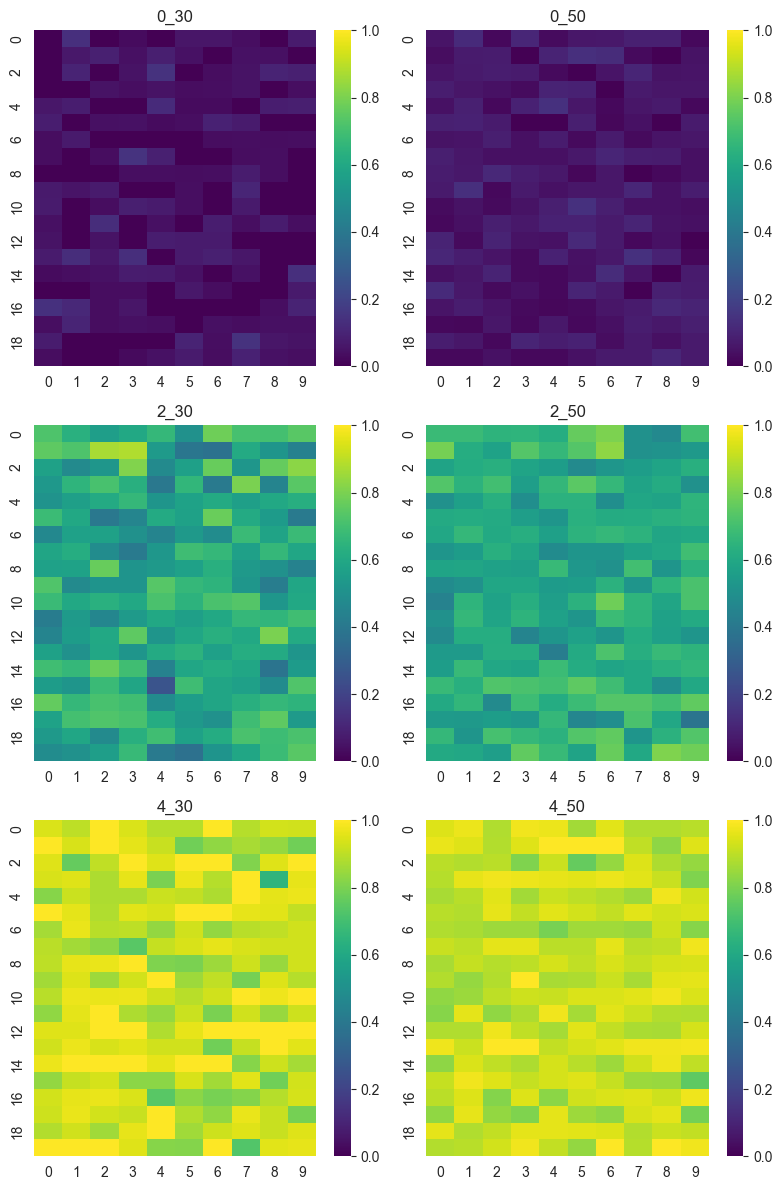

In [10]:
for col in overlap_stats_df.columns:
    overlap_stats_df[col] = overlap_stats_df[col].map(lambda x: eval(x) if isinstance(x, str) else x)

ncols = 2
nrows = int(np.ceil(len(overlap_stats_df.columns) / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(4 * ncols, 4 * nrows))
axes = axes.flatten()

for i, col in enumerate(overlap_stats_df.columns):
    mat = np.vstack(overlap_stats_df[col].values)
    sns.heatmap(mat, ax=axes[i], cmap="viridis", cbar=True, vmin=0, vmax=1)
    axes[i].set_title(col)

for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()


### Create prior network with overlapped targets

In [29]:
prior_counts = {
    'TF1': 30, 'TF2': 28, 'TF3': 25, 'TF4': 26, 'TF5': 20,
    'TF6': 26, 'TF7': 29, 'TF8': 28, 'TF9': 28, 'TF10': 34,
    'TF100': 35, 'TF50': 32
}

tfs, targets, weights = [], [], []
i = 1
for tf, n in prior_counts.items():
    for _ in range(n):
        tfs.append(tf)
        targets.append(f'G{i}')
        weights.append(np.random.choice([1, -1]))
        i += 1
prior_net = pd.DataFrame({'source': tfs, 'target': targets, 'weight': weights})
print(prior_net)

prior_grouped = prior_net.groupby("source").size().reset_index(name="num_targets")
print(prior_grouped)

prior_overlapped_updated = {}
group_size = 5  # Define the size of each group to create overlaps
alpha = 4  # Overlap factor

unique_tfs = prior_net['source'].unique()

if alpha > 0:
    for i in range(0, len(unique_tfs), group_size):
        current_tfs = unique_tfs[i:i + group_size]
        current_targets = prior_net[prior_net['source'].isin(current_tfs)]['target'].unique().tolist()
        # shuffle current targets
        np.random.shuffle(current_targets)
        print(f"\n\nCurrent TFs: {current_tfs}")
        print(f"Current TFs Targets: {current_targets}")

        for tf in current_tfs:
            added_targets = prior_overlapped_updated.get(tf, [])
            original_target_count = prior_grouped[prior_grouped['source'] == tf]['num_targets'].values[0]

            mean = (len(current_targets) - 1) / 2
            std = len(current_targets) / (len(current_tfs) * alpha)

            while len(added_targets) < original_target_count:
                random_idx = int(np.random.normal(mean, std))

                if 0 <= random_idx < len(current_targets):
                    target = current_targets[random_idx]
                    if target not in added_targets:
                        added_targets.append(target)

            prior_overlapped_updated[tf] = added_targets

    print("Prior Overlapped Updated")
    print(prior_overlapped_updated)

    # Create a new prior network with overlapped targets with random weights
    new_prior_net = []
    for tf, targets in prior_overlapped_updated.items():
        for target in targets:
            weight = np.random.choice([1, -1])
            new_prior_net.append({'source': tf, 'target': target, 'weight': weight})

    new_prior_net_df = pd.DataFrame(new_prior_net)
else:
    new_prior_net_df = prior_net.copy()

print("\n\n------------------------")
print(new_prior_net_df)

    source target  weight
0      TF1     G1      -1
1      TF1     G2       1
2      TF1     G3      -1
3      TF1     G4      -1
4      TF1     G5       1
..     ...    ...     ...
336   TF50   G337       1
337   TF50   G338       1
338   TF50   G339       1
339   TF50   G340       1
340   TF50   G341      -1

[341 rows x 3 columns]
   source  num_targets
0     TF1           30
1    TF10           34
2   TF100           35
3     TF2           28
4     TF3           25
5     TF4           26
6     TF5           20
7    TF50           32
8     TF6           26
9     TF7           29
10    TF8           28
11    TF9           28


Current TFs: ['TF1' 'TF2' 'TF3' 'TF4' 'TF5']
Current TFs Targets: ['G36', 'G50', 'G102', 'G61', 'G79', 'G35', 'G27', 'G25', 'G62', 'G63', 'G31', 'G75', 'G2', 'G29', 'G70', 'G30', 'G101', 'G47', 'G111', 'G55', 'G85', 'G109', 'G42', 'G124', 'G60', 'G114', 'G53', 'G93', 'G76', 'G37', 'G20', 'G112', 'G72', 'G51', 'G120', 'G46', 'G116', 'G49', 'G105', 'G1', 'G73', '

In [30]:
net_file = "simulated_data/simulated_prior_data.tsv"
effect_map = {"upregulates-expression": 1, "downregulates-expression": -1}
new_prior_net_df = pd.read_csv(
    net_file,
    sep="\t",
    names=["source", "weight", "target"],
    usecols=[0, 1, 2],
    converters={"weight": effect_map.get}
)[["source", "target", "weight"]]

group_size = 5

# Overlap coefficient
overlap_coefficient_list = []
tfs = new_prior_net_df['source'].unique()

for i in range(0, len(tfs), group_size):
    current_tfs = tfs[i:i + group_size]
    overlap_coefficient = []
    for j in range(len(current_tfs)):
        for k in range(j + 1, len(current_tfs)):
            targets_tf1 = set(new_prior_net_df[new_prior_net_df['source'] == current_tfs[j]]['target'])
            targets_tf2 = set(new_prior_net_df[new_prior_net_df['source'] == current_tfs[k]]['target'])
            intersection_targets = targets_tf1.intersection(targets_tf2)
            overlap_coefficient.append(len(intersection_targets) / min(len(targets_tf1), len(targets_tf2)))

    overlap_coefficient_list.append(overlap_coefficient)

print(overlap_coefficient_list)
average_groupwise_overlap_coefficient = [sum(group) / len(group) for group in overlap_coefficient_list]
print(average_groupwise_overlap_coefficient)

[[0.9464285714285714, 0.9107142857142857, 0.9512195121951219, 0.9574468085106383, 0.9821428571428571, 1.0, 0.9787234042553191, 1.0, 0.9787234042553191, 0.926829268292683], [0.9183673469387755, 0.9411764705882353, 0.9622641509433962, 0.9056603773584906, 0.9183673469387755, 0.9387755102040817, 0.9183673469387755, 0.9411764705882353, 0.9411764705882353, 0.8928571428571429], [0.9591836734693877, 0.9523809523809523, 0.9782608695652174, 0.9591836734693877, 0.9285714285714286, 0.9130434782608695, 0.8979591836734694, 0.9047619047619048, 0.9523809523809523, 0.9130434782608695], [0.926829268292683, 0.9512195121951219, 1.0, 1.0, 0.9772727272727273, 1.0, 0.9772727272727273, 0.9387755102040817, 0.9375, 1.0], [0.9767441860465116, 0.9629629629629629, 0.9259259259259259, 0.9387755102040817, 1.0, 0.9302325581395349, 0.9534883720930233, 0.9259259259259259, 0.9591836734693877, 0.8775510204081632], [1.0, 0.975609756097561, 0.975609756097561, 0.9512195121951219, 0.9607843137254902, 0.9245283018867925, 0.94

### Create weight on prior network

In [31]:
prior_net = new_prior_net_df.copy()

# prior_net = pd.DataFrame(
#     {
#         'source': ['TF1', 'TF1', 'TF1', 'TF1', 'TF2', 'TF2','TF2', 'TF3', 'TF3', 'TF3'],
#         'target': ['G1', 'G2', 'G3', 'G4', 'G3', 'G4', 'G5', 'G4', 'G6', 'G7'],
#         'weight': [1, 1, -1, 1, 1, 1, 1, -1, -1, 1]
#     }
# )

print(prior_net)

# Count how many unique sources each target has
target_source_counts = prior_net.groupby('target')['source'].nunique()

# Map the counts back to the DataFrame and calculate weight_factor
prior_net['weight_factor'] = prior_net['target'].map(target_source_counts).apply(lambda x: 1 / x)

print(prior_net)

      source target  weight
0       TF_1  G_556       1
1       TF_1  G_729      -1
2       TF_1  G_231       1
3       TF_1  G_283       1
4       TF_1   G_59      -1
...      ...    ...     ...
4960  TF_100  G_952       1
4961  TF_100  G_334      -1
4962  TF_100  G_121      -1
4963  TF_100  G_992      -1
4964  TF_100  G_606      -1

[4965 rows x 3 columns]
      source target  weight  weight_factor
0       TF_1  G_556       1       0.071429
1       TF_1  G_729      -1       0.200000
2       TF_1  G_231       1       0.200000
3       TF_1  G_283       1       0.250000
4       TF_1   G_59      -1       0.090909
...      ...    ...     ...            ...
4960  TF_100  G_952       1       0.200000
4961  TF_100  G_334      -1       0.200000
4962  TF_100  G_121      -1       1.000000
4963  TF_100  G_992      -1       0.125000
4964  TF_100  G_606      -1       0.090909

[4965 rows x 4 columns]


In [32]:
import pandas as pd

prior_net = pd.DataFrame({
    'source': ['F1', 'F1', 'F2', 'F2'],
    'target': ['T1', 'T2', 'T1', 'T3'],
    'scores': [5.2, 5.2, 3.1, 3.1]
})

scores_series = pd.Series({
    'F1': 5.2,
    'F2': 3.1
})

prior_net['scores'] = prior_net['source'].map(scores_series)

# compute normalized weights per target
prior_net['weight_factor'] = prior_net['scores'] / prior_net.groupby('target')['scores'].transform('sum')

prior_net

,source,target,scores,weight_factor
0,F1,T1,5.2,0.626506
1,F1,T2,5.2,1.000000
2,F2,T1,3.1,0.373494
3,F2,T3,3.1,1.000000


In [33]:
prior_net = pd.DataFrame({
    'source': ['F1', 'F1', 'F2', 'F2'],
    'target': ['T1', 'T2', 'T1', 'T3'],
    'scores': [5.2, 5.2, 3.1, 3.1]
})
prior_net

,source,target,scores
0,F1,T1,5.2
1,F1,T2,5.2
2,F2,T1,3.1
3,F2,T3,3.1


In [34]:
kale_weighted_scores = pd.read_csv("simulated_data/_kale_scores_weighted.tsv", sep="\t", index_col=0)
ground_truths = pd.read_csv("simulated_data/simulated_ground_truth.tsv", sep="\t", index_col=0)

# Calculate AUC
# Melt the DataFrame to long format
scores_out = kale_weighted_scores.reset_index().rename(columns={"index": "Cell"})
scores_out = pd.melt(scores_out, id_vars=["Cell"], var_name="TF", value_name="Value")
scores_out["Cell_TF"] = scores_out["Cell"] + "_" + scores_out["TF"]
scores_out = scores_out[["Cell_TF", "Value"]]

# Merge with ground truths
ground_truths = ground_truths.reset_index().rename(columns={"index": "Cell"})
ground_truths = pd.melt(ground_truths, id_vars=["Cell"], var_name="TF", value_name="Value")
ground_truths["Cell_TF"] = ground_truths["Cell"] + "_" + ground_truths["TF"]
ground_truths = ground_truths[["Cell_TF", "Value"]]
scores_merged = scores_out.merge(ground_truths, on="Cell_TF", suffixes=("_pred", "_true"))

# Sort by Cell_TF to ensure consistent ordering
scores_merged = scores_merged.sort_values(by="Value_pred", ascending=False)
scores_merged['y_true'] = (scores_merged['Value_true'] == 1.0).astype(int)

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(scores_merged['y_true'], scores_merged['Value_pred'])
roc_auc = auc(fpr, tpr)
print(f"Weighted KALE AUC: {roc_auc:.4f}")

ValueError: Input contains NaN.

In [5]:
kale_weighted_scores = pd.read_csv("simulated_data/_kale_scores_weighted.tsv", sep="\t", index_col=0)
ground_truths = pd.read_csv("simulated_data/simulated_ground_truth.tsv", sep="\t", index_col=0)

# # Prepare prediction data
# scores_out = kale_weighted_scores.reset_index().rename(columns={"index": "Cell"})
# scores_out = pd.melt(scores_out, id_vars=["Cell"], var_name="TF", value_name="Value")
# scores_out["Cell_TF"] = scores_out["Cell"] + "_" + scores_out["TF"]
# scores_out = scores_out[["Cell_TF", "Value"]]
#
# # Prepare ground truth data
# ground_truths = ground_truths.reset_index().rename(columns={"index": "Cell"})
# ground_truths = pd.melt(ground_truths, id_vars=["Cell"], var_name="TF", value_name="Value")
# ground_truths["Cell_TF"] = ground_truths["Cell"] + "_" + ground_truths["TF"]
# ground_truths = ground_truths[["Cell_TF", "Value"]]
#
# # Merge and clean
# scores_merged = scores_out.merge(ground_truths, on="Cell_TF", suffixes=("_pred", "_true"))
# scores_merged = scores_merged.dropna(subset=["Value_pred", "Value_true"])  # fix
#
# # Sort and compute AUC
# scores_merged = scores_merged.sort_values(by="Value_pred", ascending=False)
# scores_merged["y_true"] = (scores_merged["Value_true"] == 1.0).astype(int)
#
# fpr, tpr, _ = roc_curve(scores_merged["y_true"], scores_merged["Value_pred"])
# roc_auc = auc(fpr, tpr)
# print(f"Weighted KALE AUC: {roc_auc:.4f}")

# check if kale_weighted_scores has any missing values
print("Missing values in KALE weighted scores:", kale_weighted_scores.isnull().sum().sum())
# check if ground_truths has any missing values
print("Missing values in ground truths:", ground_truths.isnull().sum().sum())

# Find row and column indexes with missing values
missing_rows, missing_cols = np.where(kale_weighted_scores.isnull())
for row, col in zip(missing_rows, missing_cols):
    print(f"Missing value at row {kale_weighted_scores.index[row]}, column {kale_weighted_scores.columns[col]}")

Missing values in KALE weighted scores: 2
Missing values in ground truths: 0
Missing value at row Cell_221, column TF_73
Missing value at row Cell_428, column TF_89


In [9]:
# Run kale without weights
print("\nRunning KALE for test case")
!uv run src/kale.py --gene_exp_file simulated_data/simulated_scRNASeq_data.tsv --prior_file simulated_data/simulated_prior_data.tsv --output_file test_dir/_kale_scores_old.tsv --pvalue_output_file test_dir/_kale_pvalues_old.tsv --ignore_zeros False --cores 8 --method rank_of_ranks --min_targets 1 --weighted False

#
# # Run with a weighted option 1
# print("\nRunning KALE with weights for test case")
# !uv run src/kale.py --gene_exp_file simulated_data/simulated_scRNASeq_data.tsv --prior_file simulated_data/simulated_prior_data.tsv --output_file simulated_data/_kale_scores_test2.tsv --pvalue_output_file simulated_data/_kale_pvalues_test2.tsv --ignore_zeros False --cores 8 --method rank_of_ranks --min_targets 1 --weighted True --weighted_power_factor 0
#
#
# # Run with a weighted option 2 with power factor 1
# print("\nRunning KALE with weights for test case")
# !uv run src/kale.py --gene_exp_file simulated_data/simulated_scRNASeq_data.tsv --prior_file simulated_data/simulated_prior_data.tsv --output_file simulated_data/_kale_scores_test3.tsv --pvalue_output_file simulated_data/_kale_pvalues_test3.tsv --ignore_zeros False --cores 8 --method rank_of_ranks --min_targets 1 --weighted True --weighted_power_factor 1
#
#
# # Run with a weighted option 2 with power factor 2
# print("\nRunning KALE with weights for test case")
# !uv run src/kale.py --gene_exp_file simulated_data/simulated_scRNASeq_data.tsv --prior_file simulated_data/simulated_prior_data.tsv --output_file simulated_data/_kale_scores_test4.tsv --pvalue_output_file simulated_data/_kale_pvalues_test4.tsv --ignore_zeros False --cores 8 --method rank_of_ranks --min_targets 1 --weighted True --weighted_power_factor 2


Running KALE for test case
Using raw gene expression as input for per-cell ranking...
Starting TF activity using 8 cores.
Running in parallel with CORES_USED=8.
Processing cells in parallel: 100%|███████| 2000/2000 [00:01<00:00, 1264.79it/s]
[Parallel(n_jobs=8)]: Done 1824 out of 2000 | elapsed:    2.1s
[Parallel(n_jobs=8)]: Done 1985 out of 2000 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done 2000 out of 2000 | elapsed:    2.2s finished

Aggregating results...
kale completed
Kale TF activity scores and p-values have been saved.


In [9]:
kale \
- -gene_exp_file.. / scDataStatProject / simulated_data / simulated_scRNASeq_data.tsv \
- -prior_file.. / scDataStatProject / simulated_data / simulated_prior_data.tsv \
- -output_scores.. / scDataStatProject / test_dir / scores_test_from_package.tsv \
- -output_pvalues.. / scDataStatProject / test_dir / pvalues_test_from_package.tsv \
- -cores
8 \
- -ignore_zeros
False \
- -min_targets
1 \
 \
    kale \
    - -gene_exp_file.. / scDatastatProject / simulated_data / simulated_scRNASeq_data.tsv \
    - -prior_file.. / scDatastatProject / simulated_data / simulated_prior_data.tsv \
    - -output_scores.. / scDatastatProject / simulated_data / scores_test2.tsv \
    - -output_pvalues.. / scDatastatProject / simulated_data / pvalues_test2.tsv \
    - -cores
8 \
- -min_targets
1 \
- -weighted \
 \
    kale \
    - -gene_exp_file.. / scDatastatProject / simulated_data / simulated_scRNASeq_data.tsv \
    - -prior_file.. / scDatastatProject / simulated_data / simulated_prior_data.tsv \
    - -output_scores.. / scDatastatProject / simulated_data / scores_test3.tsv \
    - -output_pvalues.. / scDatastatProject / simulated_data / pvalues_test3.tsv \
    - -cores
8 \
- -min_targets
1 \
- -weighted \
- -weighted_power_factor
1

kale \
- -gene_exp_file.. / scDatastatProject / simulated_data / simulated_scRNASeq_data.tsv \
- -prior_file.. / scDatastatProject / simulated_data / simulated_prior_data.tsv \
- -output_scores.. / scDatastatProject / simulated_data / scores_test4.tsv \
- -output_pvalues.. / scDatastatProject / simulated_data / pvalues_test4.tsv \
- -cores
8 \
- -min_targets
1 \
- -weighted \
- -weighted_power_factor
2

SyntaxError: invalid syntax (2125710161.py, line 2)